# Import libraries and datasets

In [1]:
#pip install mlforecast==0.13.0
#pip install skforecast
#pip install lazypredict

In [2]:
# Libraries

import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

from pycaret.regression import *

import optuna

import warnings

warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('data_energy.csv', index_col='datetime', parse_dates=True, infer_datetime_format=True)

In [4]:
df.columns

Index(['inverter', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'global_tilted_irradiance (W/m²)',
       'terrestrial_radiation (W/m²)', 'shortwave_radiation_instant (W/m²)',
       'direct_radiation_instant (W/m²)', 'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith', 'id',
       'panel_size', 'energy'],
      dtype='object')

In [5]:
df = df.drop(['global_tilted_irradiance (W/m²)'],axis=1)

In [6]:
df.shape

(9555, 30)

In [7]:
df

inverter  temperature_2m (°C)  relative_humidity_2m (%)  \
datetime                                                                       
2023-11-03 02:00:00       0.0                 19.6                      76.0   
2023-11-03 03:00:00       0.0                 19.2                      75.0   
2023-11-03 04:00:00       0.0                 17.9                      80.0   
2023-11-03 05:00:00       0.0                 17.4                      75.0   
2023-11-03 06:00:00       0.0                 16.9                      71.0   
...                       ...                  ...                       ...   
2024-06-24 22:00:00       0.0                 26.6                      71.0   
2024-06-24 23:00:00       0.0                 25.9                      68.0   
2024-06-25 00:00:00       0.0                 25.2                      65.0   
2024-06-25 01:00:00       0.0                 24.8                      63.0   
2024-06-25 02:00:00       0.0                 24.3                      62.0   

                     apparent_temperature (°C)  precipitation (mm)  rain (mm)  \
datetime                                                                        
2023-11-03 02:00:00                       20.4                 0.0        0.0   
2023-11-03 03:00:00                       19.8                 0.0        0.0   
2023-11-03 04:00:00                       18.8                 0.0        0.0   
2023-11-03 05:00:00                       17.6                 0.0        0.0   
2023-11-03 06:00:00                       17.1                 0.0        0.0   
...                                        ...                 ...        ...   
2024-06-24 22:00:00                       28.9                 0.0        0.0   
2024-06-24 23:00:00                       27.3                 0.0        0.0   
2024-06-25 00:00:00                       26.1                 0.0        0.0   
2024-06-25 01:00:00                       25.6                 0.0        0.0   
2024-06-25 02:00:00                       25.3                 0.0        0.0   

                     cloud_cover (%)  cloud_cover_low (%)  \
datetime                                                    
2023-11-03 02:00:00              1.0                  1.0   
2023-11-03 03:00:00              1.0                  1.0   
2023-11-03 04:00:00              0.0                  0.0   
2023-11-03 05:00:00              1.0                  0.0   
2023-11-03 06:00:00              8.0                  0.0   
...                              ...                  ...   
2024-06-24 22:00:00              0.0                  0.0   
2024-06-24 23:00:00              0.0                  0.0   
2024-06-25 00:00:00              0.0                  0.0   
2024-06-25 01:00:00              0.0                  0.0   
2024-06-25 02:00:00              0.0                  0.0   

                     cloud_cover_mid (%)  cloud_cover_high (%)  ...  \
datetime                                                        ...   
2023-11-03 02:00:00                  0.0                   0.0  ...   
2023-11-03 03:00:00                  0.0                   0.0  ...   
2023-11-03 04:00:00                  0.0                   0.0  ...   
2023-11-03 05:00:00                  0.0                   2.0  ...   
2023-11-03 06:00:00                  0.0                  27.0  ...   
...                                  ...                   ...  ...   
2024-06-24 22:00:00                  0.0                   0.0  ...   
2024-06-24 23:00:00                  0.0                   0.0  ...   
2024-06-25 00:00:00                  0.0                   0.0  ...   
2024-06-25 01:00:00                  0.0                   0.0  ...   
2024-06-25 02:00:00                  0.0                   0.0  ...   

                     shortwave_radiation_instant (W/m²)  \
datetime                                                  
2023-11-03 02:00:00                                 0.0   
2023-11-03 03:00:00            

In [8]:
df = df.reset_index()
df = df.sort_values(by='datetime')
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

In [9]:
df

datetime  inverter  temperature_2m (°C)  \
0    2023-11-03 02:00:00       0.0                 19.6   
3185 2023-11-03 02:00:00       0.0                 19.6   
6370 2023-11-03 02:00:00       0.0                 19.6   
1    2023-11-03 03:00:00       0.0                 19.2   
3186 2023-11-03 03:00:00       0.0                 19.2   
...                  ...       ...                  ...   
3183 2024-06-25 01:00:00       0.0                 24.8   
6368 2024-06-25 01:00:00       0.0                 24.8   
6369 2024-06-25 02:00:00       0.0                 24.3   
3184 2024-06-25 02:00:00       0.0                 24.3   
9554 2024-06-25 02:00:00       0.0                 24.3   

      relative_humidity_2m (%)  apparent_temperature (°C)  precipitation (mm)  \
0                         76.0                       20.4                 0.0   
3185                      76.0                       20.4                 0.0   
6370                      76.0                       20.4                 0.0   
1                         75.0                       19.8                 0.0   
3186                      75.0                       19.8                 0.0   
...                        ...                        ...                 ...   
3183                      63.0                       25.6                 0.0   
6368                      63.0                       25.6                 0.0   
6369                      62.0                       25.3                 0.0   
3184                      62.0                       25.3                 0.0   
9554                      62.0                       25.3                 0.0   

      rain (mm)  cloud_cover (%)  cloud_cover_low (%)  cloud_cover_mid (%)  \
0           0.0              1.0                  1.0                  0.0   
3185        0.0              1.0                  1.0                  0.0   
6370        0.0              1.0                  1.0                  0.0   
1           0.0              1.0                  1.0                  0.0   
3186        0.0              1.0                  1.0                  0.0   
...         ...              ...                  ...                  ...   
3183        0.0              0.0                  0.0                  0.0   
6368        0.0              0.0                  0.0                  0.0   
6369        0.0              0.0                  0.0                  0.0   
3184        0.0              0.0                  0.0                  0.0   
9554        0.0              0.0                  0.0                  0.0   

      ...  diffuse_radiation_instant (W/m²)  \
0     ...                               0.0   
3185  ...                               0.0   
6370  ...                               0.0   
1     ...                               0.0   
3186  ...                               0.0   
...   ...                               ...   
3183  ...                               0.0   
6368  ...                               0.0   
6369  ...                               0.0   
3184  ...                               0.0   
9554  ...                               0.0   

      direct_normal_irradiance_instant (W/m²)  \
0                                         0.0   
3185                                      0.0   
6370                                      0.0   
1                                         0.0   
3186                                      0.0   
...                                       ...   
3183                                      0.0   
6368                                      0.0   
6369                                      0.0   
3184                                      0.0   
9554                                      0.0   

      terrestrial_radiation_instant (W/m²)  azimuth  zenith         id  \
0                                      0.0      -67     141  inverter1   
3185                                   0.0      -67     141  inverter2   
6370                 

df1 = df[df['id']=='inverter1']
df1 = df1.drop('id',axis=1)

df2 = df[df['id']=='inverter2']
df2 = df2.drop('id',axis=1)

df3 = df[df['id']=='inverter3']
df3 = df3.drop('id',axis=1)

# split datasets

In [10]:
end_train = '2024-06-15 00:00:00'

evaluation = df.loc[df['datetime'] >= end_train]

df = df.loc[df['datetime'] < end_train]

In [11]:
df

datetime  inverter  temperature_2m (°C)  \
0    2023-11-03 02:00:00       0.0                 19.6   
3185 2023-11-03 02:00:00       0.0                 19.6   
6370 2023-11-03 02:00:00       0.0                 19.6   
1    2023-11-03 03:00:00       0.0                 19.2   
3186 2023-11-03 03:00:00       0.0                 19.2   
...                  ...       ...                  ...   
6125 2024-06-14 22:00:00       0.0                 31.2   
9310 2024-06-14 22:00:00       0.0                 31.2   
6126 2024-06-14 23:00:00       0.0                 29.9   
9311 2024-06-14 23:00:00       0.0                 29.9   
2941 2024-06-14 23:00:00       0.0                 29.9   

      relative_humidity_2m (%)  apparent_temperature (°C)  precipitation (mm)  \
0                         76.0                       20.4                 0.0   
3185                      76.0                       20.4                 0.0   
6370                      76.0                       20.4                 0.0   
1                         75.0                       19.8                 0.0   
3186                      75.0                       19.8                 0.0   
...                        ...                        ...                 ...   
6125                      37.0                       31.4                 0.0   
9310                      37.0                       31.4                 0.0   
6126                      40.0                       30.0                 0.0   
9311                      40.0                       30.0                 0.0   
2941                      40.0                       30.0                 0.0   

      rain (mm)  cloud_cover (%)  cloud_cover_low (%)  cloud_cover_mid (%)  \
0           0.0              1.0                  1.0                  0.0   
3185        0.0              1.0                  1.0                  0.0   
6370        0.0              1.0                  1.0                  0.0   
1           0.0              1.0                  1.0                  0.0   
3186        0.0              1.0                  1.0                  0.0   
...         ...              ...                  ...                  ...   
6125        0.0              0.0                  0.0                  0.0   
9310        0.0              0.0                  0.0                  0.0   
6126        0.0              0.0                  0.0                  0.0   
9311        0.0              0.0                  0.0                  0.0   
2941        0.0              0.0                  0.0                  0.0   

      ...  diffuse_radiation_instant (W/m²)  \
0     ...                               0.0   
3185  ...                               0.0   
6370  ...                               0.0   
1     ...                               0.0   
3186  ...                               0.0   
...   ...                               ...   
6125  ...                               0.0   
9310  ...                               0.0   
6126  ...                               0.0   
9311  ...                               0.0   
2941  ...                               0.0   

      direct_normal_irradiance_instant (W/m²)  \
0                                         0.0   
3185                                      0.0   
6370                                      0.0   
1                                         0.0   
3186                                      0.0   
...                                       ...   
6125                                      0.0   
9310                                      0.0   
6126                                      0.0   
9311                                      0.0   
2941                                      0.0   

      terrestrial_radiation_instant (W/m²)  azimuth  zenith         id  \
0                                      0.0      -67     141  inverter1   
3185                                   0.0      -67     141  inverter2   
6370                 

In [12]:
evaluation

datetime  inverter  temperature_2m (°C)  \
6127 2024-06-15 00:00:00       0.0                 29.6   
9312 2024-06-15 00:00:00       0.0                 29.6   
2942 2024-06-15 00:00:00       0.0                 29.6   
6128 2024-06-15 01:00:00       0.0                 30.0   
9313 2024-06-15 01:00:00       0.0                 30.0   
...                  ...       ...                  ...   
3183 2024-06-25 01:00:00       0.0                 24.8   
6368 2024-06-25 01:00:00       0.0                 24.8   
6369 2024-06-25 02:00:00       0.0                 24.3   
3184 2024-06-25 02:00:00       0.0                 24.3   
9554 2024-06-25 02:00:00       0.0                 24.3   

      relative_humidity_2m (%)  apparent_temperature (°C)  precipitation (mm)  \
6127                      46.0                       30.0                 0.0   
9312                      46.0                       30.0                 0.0   
2942                      46.0                       30.0                 0.0   
6128                      43.0                       30.2                 0.0   
9313                      43.0                       30.2                 0.0   
...                        ...                        ...                 ...   
3183                      63.0                       25.6                 0.0   
6368                      63.0                       25.6                 0.0   
6369                      62.0                       25.3                 0.0   
3184                      62.0                       25.3                 0.0   
9554                      62.0                       25.3                 0.0   

      rain (mm)  cloud_cover (%)  cloud_cover_low (%)  cloud_cover_mid (%)  \
6127        0.0              0.0                  0.0                  0.0   
9312        0.0              0.0                  0.0                  0.0   
2942        0.0              0.0                  0.0                  0.0   
6128        0.0              0.0                  0.0                  0.0   
9313        0.0              0.0                  0.0                  0.0   
...         ...              ...                  ...                  ...   
3183        0.0              0.0                  0.0                  0.0   
6368        0.0              0.0                  0.0                  0.0   
6369        0.0              0.0                  0.0                  0.0   
3184        0.0              0.0                  0.0                  0.0   
9554        0.0              0.0                  0.0                  0.0   

      ...  diffuse_radiation_instant (W/m²)  \
6127  ...                               0.0   
9312  ...                               0.0   
2942  ...                               0.0   
6128  ...                               0.0   
9313  ...                               0.0   
...   ...                               ...   
3183  ...                               0.0   
6368  ...                               0.0   
6369  ...                               0.0   
3184  ...                               0.0   
9554  ...                               0.0   

      direct_normal_irradiance_instant (W/m²)  \
6127                                      0.0   
9312                                      0.0   
2942                                      0.0   
6128                                      0.0   
9313                                      0.0   
...                                       ...   
3183                                      0.0   
6368                                      0.0   
6369                                      0.0   
3184                                      0.0   
9554                                      0.0   

      terrestrial_radiation_instant (W/m²)  azimuth  zenith         id  \
6127                                   0.0       -3     122  inverter2   
9312                                   0.0       -3     122  inverter3   
2942                 

In [13]:
len(evaluation)/(len(evaluation)+len(df)) # proportion of evaluation dataset

0.07629513343799058

In [14]:
df.columns

Index(['datetime', 'inverter', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'apparent_temperature (°C)',
       'precipitation (mm)', 'rain (mm)', 'cloud_cover (%)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)',
       'wind_gusts_10m (km/h)', 'is_day ()', 'sunshine_duration (s)',
       'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)',
       'terrestrial_radiation (W/m²)', 'shortwave_radiation_instant (W/m²)',
       'direct_radiation_instant (W/m²)', 'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith', 'id',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

In [15]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=1)

In [16]:
data_test = data_test.sort_values('datetime')

# metric

In [17]:
def metric(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    res = 100 * np.mean(mape)
                        #.map(lambda x: x if x<100 else 0))
    
    print(f"MAPE ML Model: {res}")   
    
    res = 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))
                        #.map(lambda x: x if x<100 else 0))
    
    print(f"SMAPE ML Model: {res}")   

# pycaret

In [22]:
X_train = data_train.drop(['datetime','id','inverter'],axis=1)
y_train = data_train['inverter']

X_test = data_test.drop(['datetime','id','inverter'],axis=1)
y_test = data_test['inverter']

In [23]:
s = setup(data = data_train.drop(['datetime','id'],axis=1), target = 'inverter', session_id=1)

In [24]:
best = s.compare_models(include = ['et', 'rf', 'gbr', 'knn', 'xgboost', 'dt', 'ada'])

In [25]:
p = pd.DataFrame({'pred':best.predict(X_test)})
p['inverter'] = y_test.reset_index()['inverter']
p['id'] = data_test.reset_index()['id']
p['pred'] = p['pred'].map(lambda x: max(x,0))

In [26]:
p

pred     inverter         id
0        0.000000     0.000000  inverter2
1       55.831234    39.655172  inverter2
2       60.405346    51.310345  inverter1
3     2162.292969  2198.875000  inverter3
4     5666.338867  5746.170833  inverter3
...           ...          ...        ...
1761  3062.828857  2838.845833  inverter2
1762  2838.917480  1626.337500  inverter3
1763  1994.693848  1879.995833  inverter2
1764  3699.005615  3642.725000  inverter1
1765  1200.499023  1339.637500  inverter1

[1766 rows x 3 columns]

GENERAL
MAPE ML Model: 104.19748437927095
SMAPE ML Model: 32.72250077937186


INVERTER1
MAPE ML Model: 193.85343465468338
SMAPE ML Model: 50.80614434884515


INVERTER2
MAPE ML Model: 87.0734437722091
SMAPE ML Model: 32.64420656259081


INVERTER3
MAPE ML Model: 31.534913180359865
SMAPE ML Model: 14.656234153918085


<Axes: >

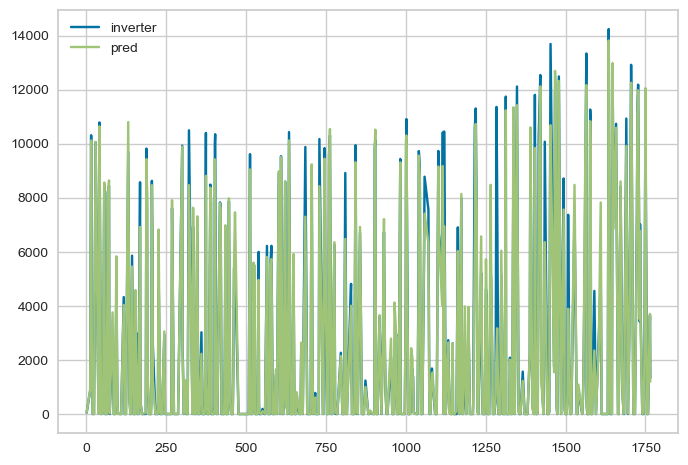

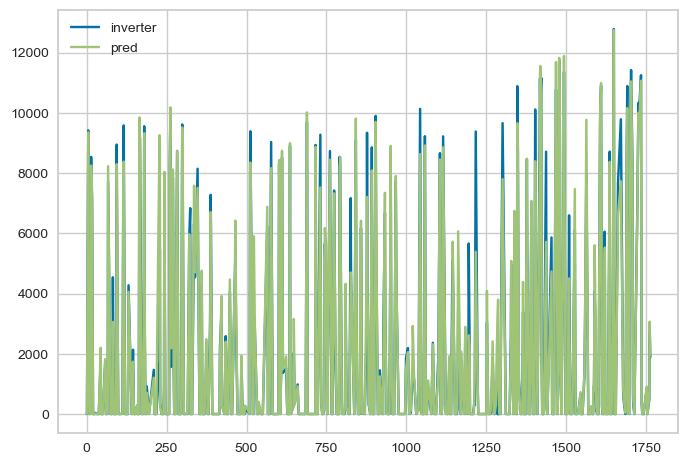

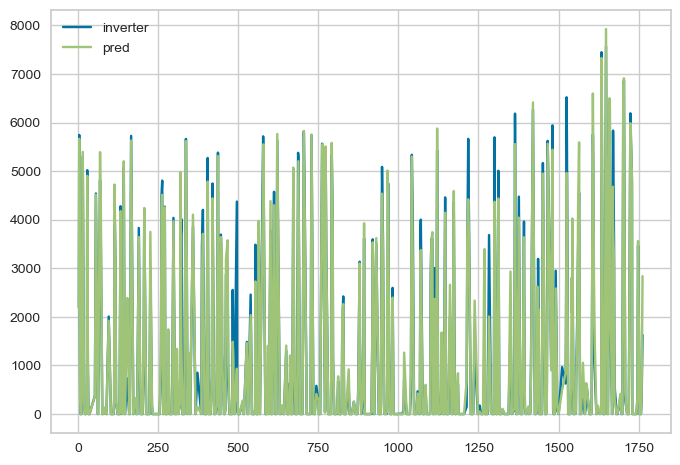

In [27]:
p1 = p[p['id']=='inverter1']
p2 = p[p['id']=='inverter2']
p3 = p[p['id']=='inverter3']

print('GENERAL')
metric(p['inverter'],p['pred'])
print('\n')
print('INVERTER1')
metric(p1['inverter'],p1['pred'])
print('\n')
print('INVERTER2')
metric(p2['inverter'],p2['pred'])
print('\n')
print('INVERTER3')
metric(p3['inverter'],p3['pred'])

p1[['inverter','pred']].plot()
p2[['inverter','pred']].plot()
p3[['inverter','pred']].plot()

<Axes: >

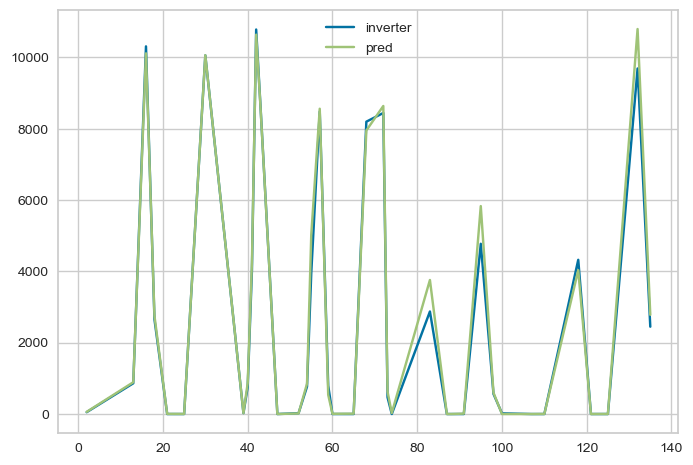

In [28]:
p1[['inverter','pred']][0:40].plot()

<Axes: >

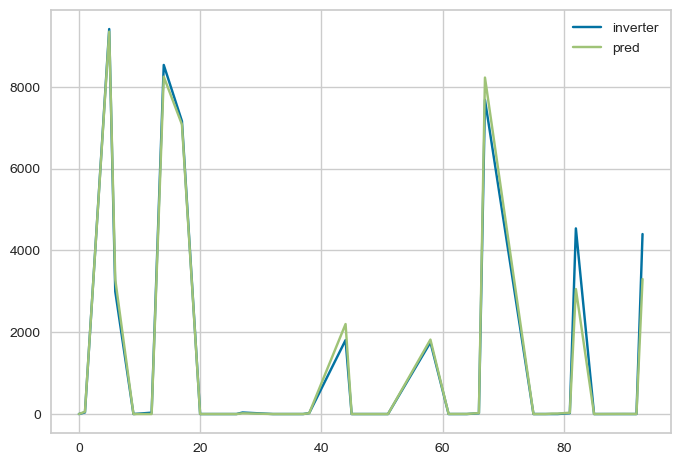

In [29]:
p2[['inverter','pred']][0:40].plot()

<Axes: >

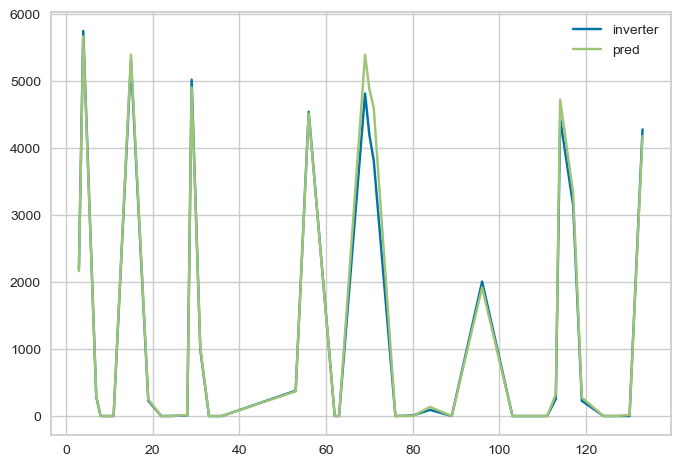

In [30]:
p3[['inverter','pred']][0:40].plot()

<Axes: xlabel='inverter', ylabel='pred'>

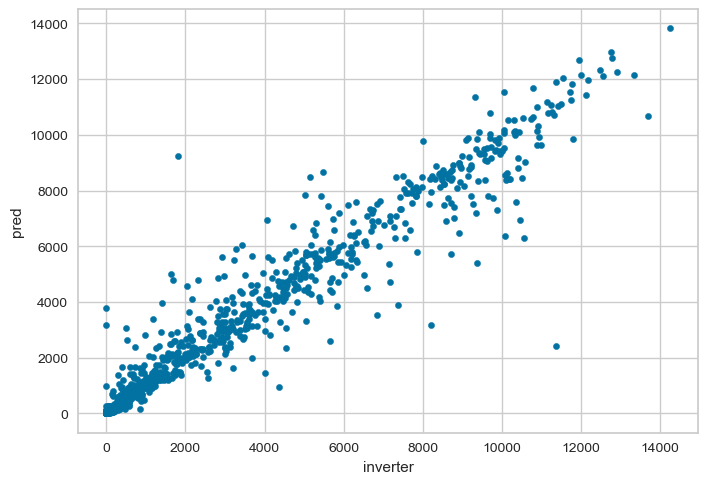

In [31]:
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

<Axes: xlabel='inverter', ylabel='pred'>

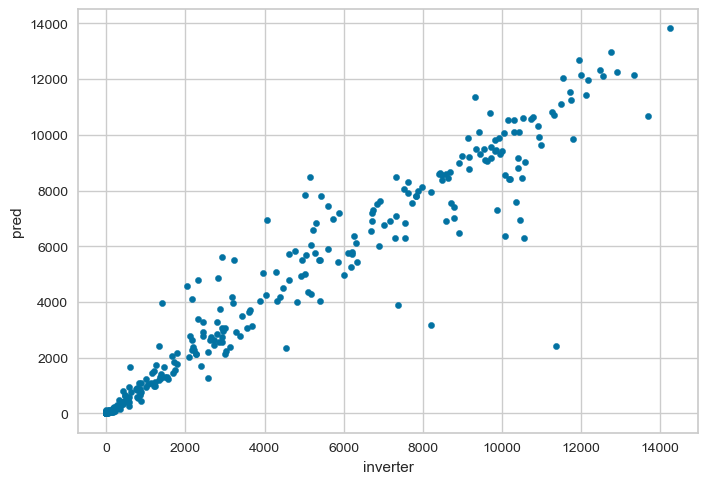

In [32]:
p1[['inverter','pred']].plot.scatter(x='inverter',y='pred')

<Axes: xlabel='inverter', ylabel='pred'>

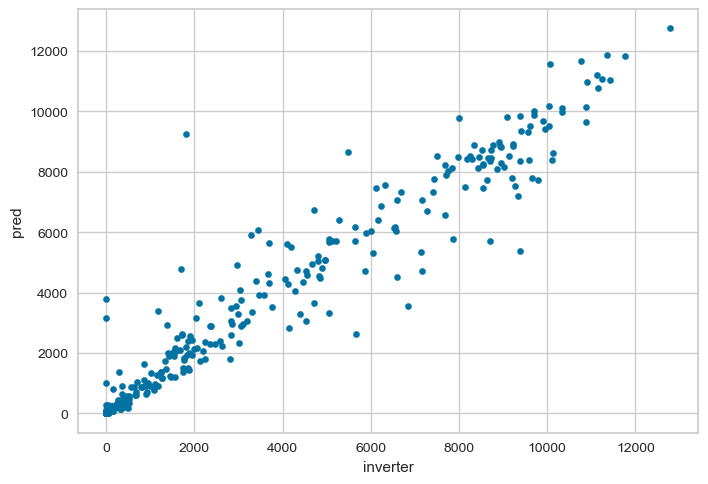

In [33]:
p2[['inverter','pred']].plot.scatter(x='inverter',y='pred')

<Axes: xlabel='inverter', ylabel='pred'>

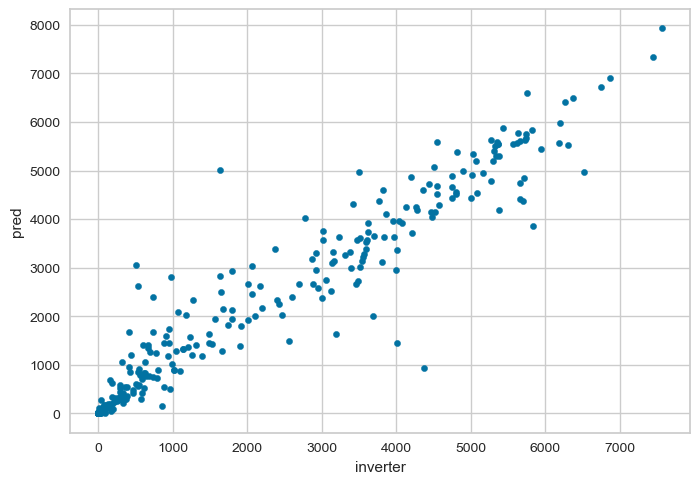

In [34]:
p3[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## pycaret - 1

In [35]:
data_train_1 = data_train[data_train['id']=='inverter1']
data_test_1 = data_test[data_test['id']=='inverter1']

In [36]:
X_train = data_train_1.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_1['inverter']

X_test = data_test_1.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_1['inverter']

In [37]:
s = setup(data = data_train_1.drop(['datetime','id'],axis=1), target = 'inverter', session_id=1)

In [38]:
best = s.compare_models(include = ['et', 'rf', 'gbr', 'knn', 'xgboost', 'dt', 'ada'])

In [39]:
p = pd.DataFrame({'pred':best.predict(X_test)})
p['inverter'] = y_test.reset_index()['inverter']
p['pred'] = p['pred'].map(lambda x: max(x,0))

In [40]:
p

pred      inverter
0       50.997396     51.310345
1      948.953773    862.120833
2    10243.340522  10311.741667
3     2523.842943   2655.004167
4        0.000000      0.000000
..            ...           ...
583   7697.445142   8795.295833
584      0.000000      0.000000
585      0.543347      0.000000
586   3953.834395   3642.725000
587   1500.947316   1339.637500

[588 rows x 2 columns]

MAPE ML Model: 93.18319564550076
SMAPE ML Model: 11.198566428121449


<Axes: >

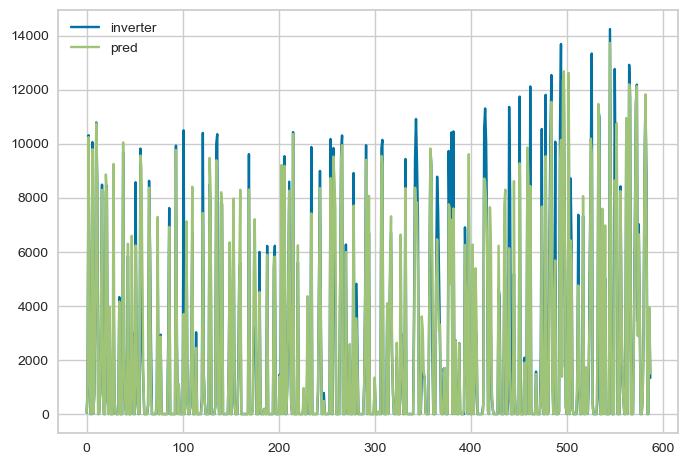

In [41]:
metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()

<Axes: >

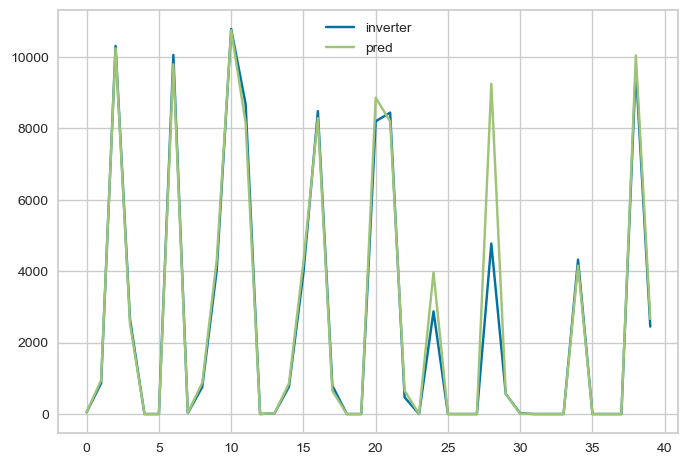

In [42]:
p[['inverter','pred']][0:40].plot()

<Axes: xlabel='inverter', ylabel='pred'>

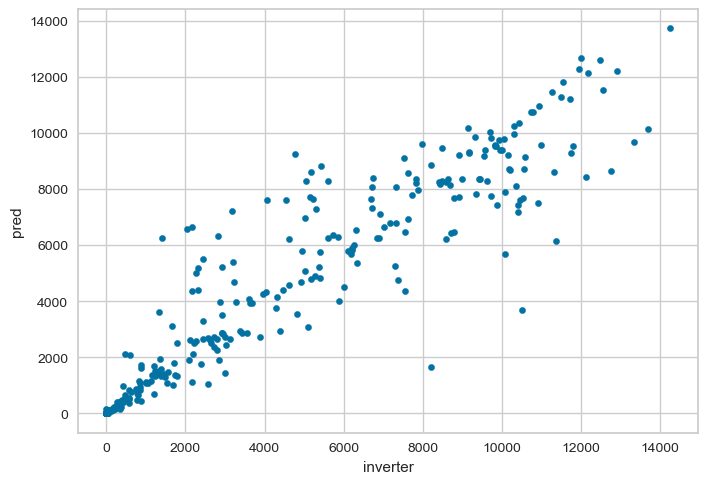

In [43]:
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## pycaret - 2

In [44]:
data_train_2 = data_train[data_train['id']=='inverter2']
data_test_2 = data_test[data_test['id']=='inverter2']

In [45]:
X_train = data_train_2.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_2['inverter']

X_test = data_test_2.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_2['inverter']

In [46]:
s = setup(data = data_train_2.drop(['datetime','id'],axis=1), target = 'inverter', session_id=1)

In [47]:
best = s.compare_models(include = ['et', 'rf', 'gbr', 'knn', 'xgboost', 'dt', 'ada'])

In [48]:
p = pd.DataFrame({'pred':best.predict(X_test)})
p['inverter'] = y_test.reset_index()['inverter']
p['pred'] = p['pred'].map(lambda x: max(x,0))

In [49]:
p

pred     inverter
0       0.000000     0.000000
1      64.168941    39.655172
2    9025.047827  9415.912500
3    3398.272140  2996.270833
4       0.000000     0.000000
..           ...          ...
587   761.743251   874.054167
588     0.000000     0.000000
589   546.963004   480.829167
590  2972.377682  2838.845833
591  1838.284839  1879.995833

[592 rows x 2 columns]

MAPE ML Model: 57.10316966190895
SMAPE ML Model: 10.03529001614216


<Axes: >

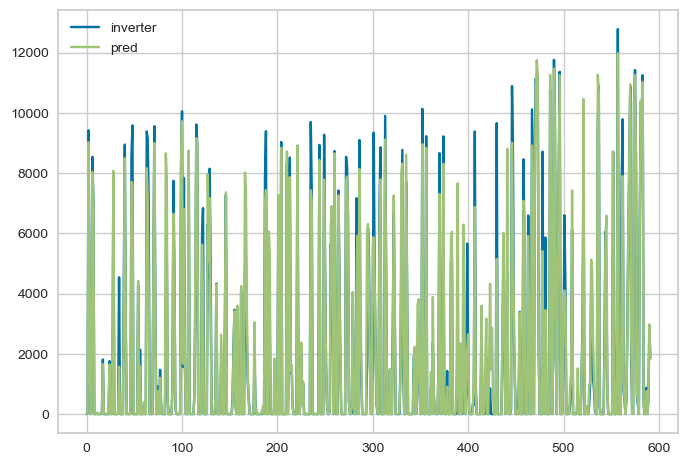

In [50]:
metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()

<Axes: >

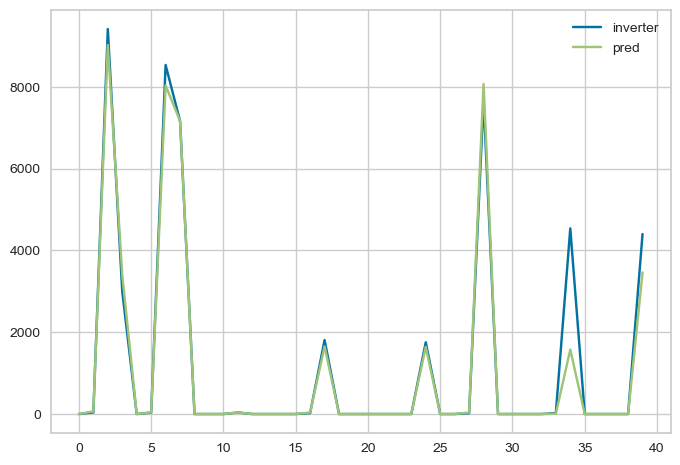

In [51]:
p[['inverter','pred']][0:40].plot()

<Axes: xlabel='inverter', ylabel='pred'>

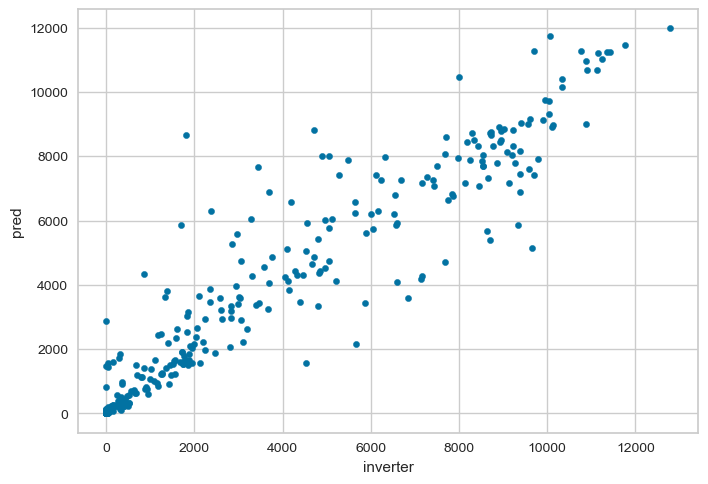

In [52]:
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## pycaret - 3

In [53]:
data_train_3 = data_train[data_train['id']=='inverter3']
data_test_3 = data_test[data_test['id']=='inverter3']

In [54]:
X_train = data_train_3.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_3['inverter']

X_test = data_test_3.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_3['inverter']

In [55]:
s = setup(data = data_train_3.drop(['datetime','id'],axis=1), target = 'inverter', session_id=1)

In [56]:
best = s.compare_models(include = ['et', 'rf', 'gbr', 'knn', 'xgboost', 'dt', 'ada'])

In [57]:
p = pd.DataFrame({'pred':best.predict(X_test)})
p['inverter'] = y_test.reset_index()['inverter']
p['pred'] = p['pred'].map(lambda x: max(x,0))

In [58]:
p

pred     inverter
0    2104.600231  2198.875000
1    5596.752456  5746.170833
2     228.284625   286.525000
3       0.000000     0.000000
4       0.000000     0.000000
..           ...          ...
581     0.000000     0.000000
582     0.000000     0.000000
583     0.000000     0.000000
584   331.103956   289.120833
585  1723.372643  1626.337500

[586 rows x 2 columns]

MAPE ML Model: 117.71727986834142
SMAPE ML Model: 12.325134013577028


<Axes: >

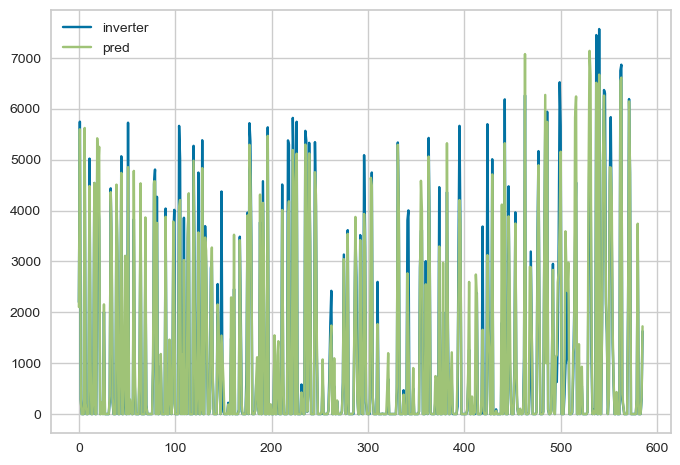

In [59]:
metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()

<Axes: >

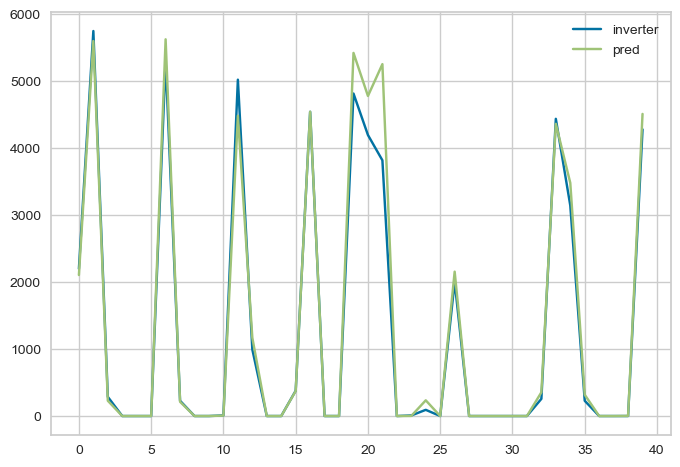

In [60]:
p[['inverter','pred']][0:40].plot()

<Axes: xlabel='inverter', ylabel='pred'>

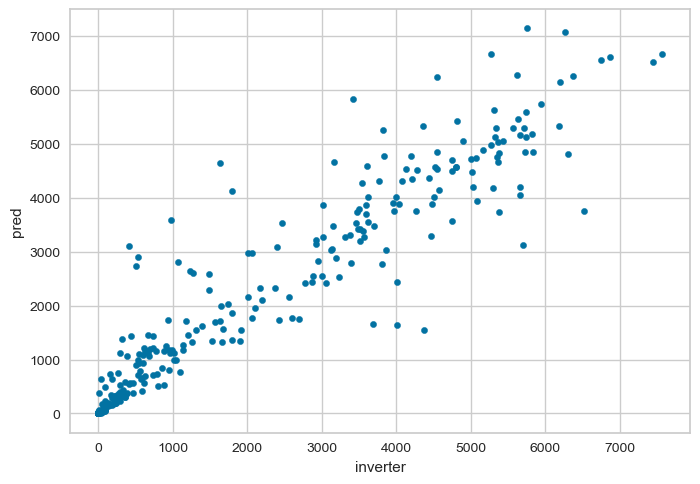

In [61]:
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# Features importance

Feature ranking:
1. feature 28 (0.886579)
2. feature 24 (0.018756)
3. feature 25 (0.011410)
4. feature 19 (0.007935)
5. feature 20 (0.007104)
6. feature 1 (0.006610)
7. feature 30 (0.006176)
8. feature 22 (0.005757)
9. feature 26 (0.005032)
10. feature 7 (0.004645)
11. feature 8 (0.003546)
12. feature 16 (0.003532)
13. feature 2 (0.003292)
14. feature 0 (0.003153)
15. feature 11 (0.003124)
16. feature 21 (0.002639)
17. feature 5 (0.002625)
18. feature 10 (0.002405)
19. feature 6 (0.002197)
20. feature 9 (0.002151)
21. feature 14 (0.002009)
22. feature 15 (0.001957)
23. feature 17 (0.001619)
24. feature 23 (0.001522)
25. feature 18 (0.001411)
26. feature 29 (0.001043)
27. feature 4 (0.000794)
28. feature 3 (0.000730)
29. feature 13 (0.000247)
30. feature 12 (0.000001)
31. feature 27 (0.000000)


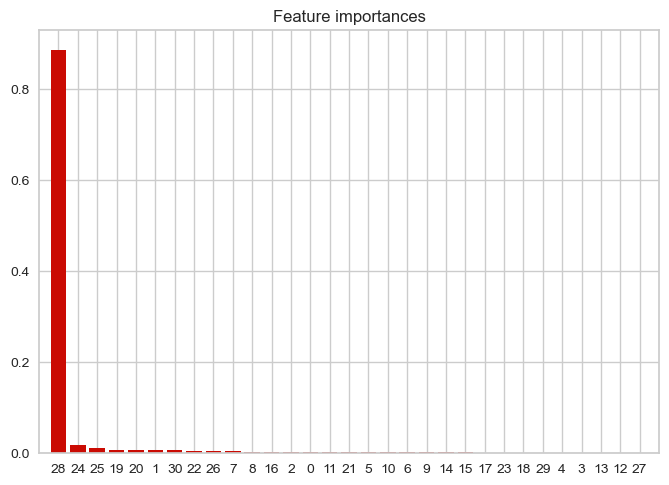

In [115]:
#from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
estimator = RandomForestRegressor(random_state=1)
estimator.fit(X_train, y_train)

# Get the feature importances
importances = estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [116]:
feature_ranking_df_et = pd.DataFrame({'feature_index': indices, 'importance': importances[indices]})
feature_ranking_df_et['column_name'] = X_train.columns[feature_ranking_df_et['feature_index']]

print("Feature ranking:")
for index, row in feature_ranking_df_et.iterrows():
    print(f"{index + 1}. feature {row['column_name']} ({row['importance']})")

Feature ranking:
1. feature energy (0.88657874042994)
2. feature terrestrial_radiation_instant (W/m²) (0.018755623940947413)
3. feature azimuth (0.01141042268678279)
4. feature terrestrial_radiation (W/m²) (0.007935144535694709)
5. feature shortwave_radiation_instant (W/m²) (0.007104030571009835)
6. feature relative_humidity_2m (%) (0.006609932530140865)
7. feature hour (0.0061762018979844725)
8. feature diffuse_radiation_instant (W/m²) (0.005756976452118249)
9. feature zenith (0.005032350719670405)
10. feature cloud_cover_mid (%) (0.004644899574505725)
11. feature cloud_cover_high (%) (0.0035461677292916893)
12. feature diffuse_radiation (W/m²) (0.0035322485639759913)
13. feature apparent_temperature (°C) (0.0032917153403874922)
14. feature temperature_2m (°C) (0.0031531912933523525)
15. feature wind_gusts_10m (km/h) (0.0031240335002880883)
16. feature direct_radiation_instant (W/m²) (0.0026386190567181263)
17. feature cloud_cover (%) (0.002624509193524515)
18. feature wind_speed_100m

## Features importance - 1

In [117]:
X_train = data_train_1.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_1['inverter']

X_test = data_test_1.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_1['inverter']

Feature ranking:
1. feature 28 (0.830888)
2. feature 20 (0.070176)
3. feature 24 (0.027776)
4. feature 22 (0.009034)
5. feature 21 (0.006331)
6. feature 26 (0.004828)
7. feature 1 (0.004629)
8. feature 19 (0.004181)
9. feature 25 (0.004018)
10. feature 7 (0.003784)
11. feature 8 (0.003453)
12. feature 15 (0.003002)
13. feature 16 (0.002998)
14. feature 2 (0.002795)
15. feature 0 (0.002682)
16. feature 5 (0.002510)
17. feature 10 (0.002061)
18. feature 17 (0.002039)
19. feature 23 (0.001904)
20. feature 6 (0.001735)
21. feature 11 (0.001696)
22. feature 9 (0.001649)
23. feature 14 (0.001530)
24. feature 30 (0.001216)
25. feature 29 (0.001028)
26. feature 18 (0.000905)
27. feature 4 (0.000477)
28. feature 3 (0.000451)
29. feature 13 (0.000216)
30. feature 12 (0.000004)
31. feature 27 (0.000000)


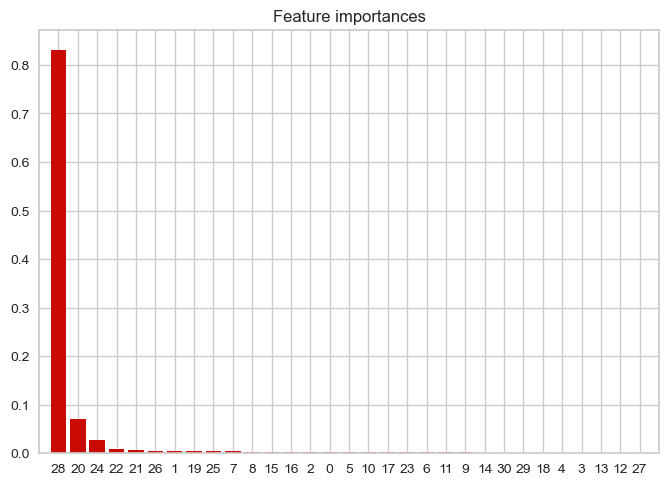

In [118]:
#from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
estimator = RandomForestRegressor(random_state=1)
estimator.fit(X_train, y_train)

# Get the feature importances
importances = estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [119]:
feature_ranking_df_et = pd.DataFrame({'feature_index': indices, 'importance': importances[indices]})
feature_ranking_df_et['column_name'] = X_train.columns[feature_ranking_df_et['feature_index']]

print("Feature ranking:")
for index, row in feature_ranking_df_et.iterrows():
    print(f"{index + 1}. feature {row['column_name']} ({row['importance']})")

Feature ranking:
1. feature energy (0.8308882024349076)
2. feature shortwave_radiation_instant (W/m²) (0.0701759940313548)
3. feature terrestrial_radiation_instant (W/m²) (0.02777593468246591)
4. feature diffuse_radiation_instant (W/m²) (0.009034297673108219)
5. feature direct_radiation_instant (W/m²) (0.006330916793924114)
6. feature zenith (0.00482826048693768)
7. feature relative_humidity_2m (%) (0.004628993852863336)
8. feature terrestrial_radiation (W/m²) (0.004181132983555357)
9. feature azimuth (0.004018373157550963)
10. feature cloud_cover_mid (%) (0.003784330737808493)
11. feature cloud_cover_high (%) (0.003453267679055076)
12. feature direct_radiation (W/m²) (0.003002301301946727)
13. feature diffuse_radiation (W/m²) (0.0029978606909355286)
14. feature apparent_temperature (°C) (0.002795405386688621)
15. feature temperature_2m (°C) (0.002681873537838483)
16. feature cloud_cover (%) (0.0025095012194312)
17. feature wind_speed_100m (km/h) (0.002061242279160445)
18. feature dire

## Features importance - 2

In [120]:
X_train = data_train_2.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_2['inverter']

X_test = data_test_2.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_2['inverter']

Feature ranking:
1. feature 28 (0.917412)
2. feature 22 (0.010170)
3. feature 24 (0.007707)
4. feature 1 (0.006173)
5. feature 26 (0.005870)
6. feature 25 (0.004616)
7. feature 8 (0.004483)
8. feature 7 (0.003660)
9. feature 16 (0.003299)
10. feature 5 (0.003046)
11. feature 0 (0.003004)
12. feature 2 (0.002988)
13. feature 19 (0.002751)
14. feature 11 (0.002452)
15. feature 20 (0.002254)
16. feature 21 (0.002137)
17. feature 10 (0.002039)
18. feature 6 (0.002006)
19. feature 9 (0.001916)
20. feature 23 (0.001912)
21. feature 17 (0.001845)
22. feature 15 (0.001788)
23. feature 29 (0.001317)
24. feature 30 (0.001302)
25. feature 18 (0.001138)
26. feature 4 (0.000952)
27. feature 14 (0.000845)
28. feature 3 (0.000681)
29. feature 13 (0.000237)
30. feature 12 (0.000000)
31. feature 27 (0.000000)


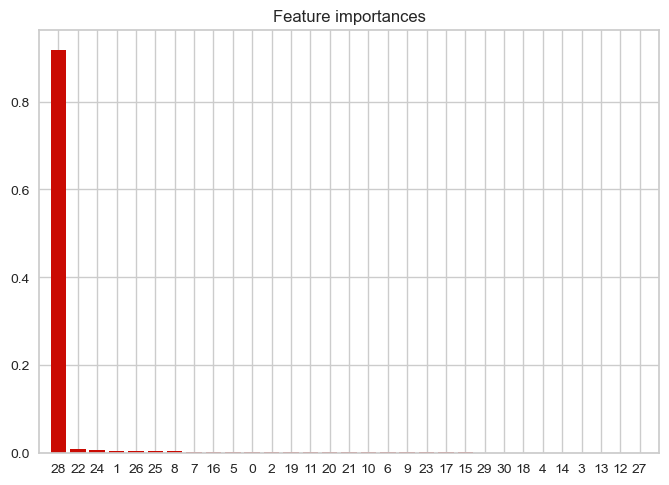

In [121]:
#from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
estimator = RandomForestRegressor(random_state=1)
estimator.fit(X_train, y_train)

# Get the feature importances
importances = estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [122]:
feature_ranking_df_et = pd.DataFrame({'feature_index': indices, 'importance': importances[indices]})
feature_ranking_df_et['column_name'] = X_train.columns[feature_ranking_df_et['feature_index']]

print("Feature ranking:")
for index, row in feature_ranking_df_et.iterrows():
    print(f"{index + 1}. feature {row['column_name']} ({row['importance']})")

Feature ranking:
1. feature energy (0.9174116869590744)
2. feature diffuse_radiation_instant (W/m²) (0.010170266542819235)
3. feature terrestrial_radiation_instant (W/m²) (0.00770664523249127)
4. feature relative_humidity_2m (%) (0.006172825294428123)
5. feature zenith (0.005869996949564906)
6. feature azimuth (0.004616258766527724)
7. feature cloud_cover_high (%) (0.0044831776186258455)
8. feature cloud_cover_mid (%) (0.003659880244957195)
9. feature diffuse_radiation (W/m²) (0.0032988496966496407)
10. feature cloud_cover (%) (0.003045572221345703)
11. feature temperature_2m (°C) (0.0030039226624621967)
12. feature apparent_temperature (°C) (0.0029878040477552313)
13. feature terrestrial_radiation (W/m²) (0.002751291757283872)
14. feature wind_gusts_10m (km/h) (0.0024516511740886983)
15. feature shortwave_radiation_instant (W/m²) (0.0022538398554732587)
16. feature direct_radiation_instant (W/m²) (0.002137073083894001)
17. feature wind_speed_100m (km/h) (0.0020389198844022955)
18. fea

## Features importance - 3

In [123]:
X_train = data_train_3.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_3['inverter']

X_test = data_test_3.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_3['inverter']

Feature ranking:
1. feature 28 (0.886579)
2. feature 24 (0.018756)
3. feature 25 (0.011410)
4. feature 19 (0.007935)
5. feature 20 (0.007104)
6. feature 1 (0.006610)
7. feature 30 (0.006176)
8. feature 22 (0.005757)
9. feature 26 (0.005032)
10. feature 7 (0.004645)
11. feature 8 (0.003546)
12. feature 16 (0.003532)
13. feature 2 (0.003292)
14. feature 0 (0.003153)
15. feature 11 (0.003124)
16. feature 21 (0.002639)
17. feature 5 (0.002625)
18. feature 10 (0.002405)
19. feature 6 (0.002197)
20. feature 9 (0.002151)
21. feature 14 (0.002009)
22. feature 15 (0.001957)
23. feature 17 (0.001619)
24. feature 23 (0.001522)
25. feature 18 (0.001411)
26. feature 29 (0.001043)
27. feature 4 (0.000794)
28. feature 3 (0.000730)
29. feature 13 (0.000247)
30. feature 12 (0.000001)
31. feature 27 (0.000000)


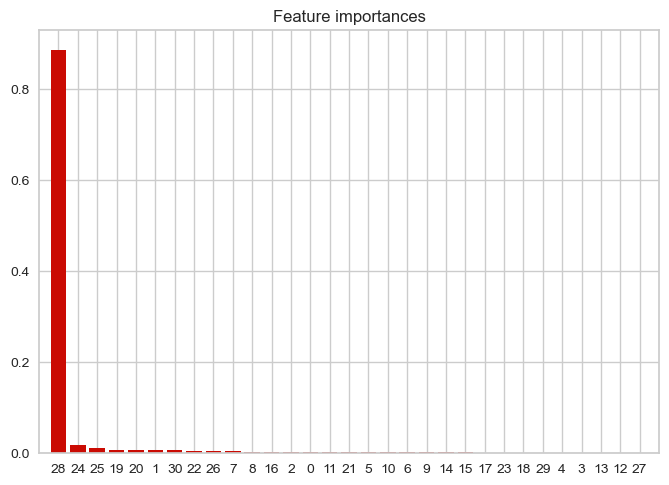

In [124]:
#from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
estimator = RandomForestRegressor(random_state=1)
estimator.fit(X_train, y_train)

# Get the feature importances
importances = estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [125]:
feature_ranking_df_et = pd.DataFrame({'feature_index': indices, 'importance': importances[indices]})
feature_ranking_df_et['column_name'] = X_train.columns[feature_ranking_df_et['feature_index']]

print("Feature ranking:")
for index, row in feature_ranking_df_et.iterrows():
    print(f"{index + 1}. feature {row['column_name']} ({row['importance']})")

Feature ranking:
1. feature energy (0.88657874042994)
2. feature terrestrial_radiation_instant (W/m²) (0.018755623940947413)
3. feature azimuth (0.01141042268678279)
4. feature terrestrial_radiation (W/m²) (0.007935144535694709)
5. feature shortwave_radiation_instant (W/m²) (0.007104030571009835)
6. feature relative_humidity_2m (%) (0.006609932530140865)
7. feature hour (0.0061762018979844725)
8. feature diffuse_radiation_instant (W/m²) (0.005756976452118249)
9. feature zenith (0.005032350719670405)
10. feature cloud_cover_mid (%) (0.004644899574505725)
11. feature cloud_cover_high (%) (0.0035461677292916893)
12. feature diffuse_radiation (W/m²) (0.0035322485639759913)
13. feature apparent_temperature (°C) (0.0032917153403874922)
14. feature temperature_2m (°C) (0.0031531912933523525)
15. feature wind_gusts_10m (km/h) (0.0031240335002880883)
16. feature direct_radiation_instant (W/m²) (0.0026386190567181263)
17. feature cloud_cover (%) (0.002624509193524515)
18. feature wind_speed_100m

# Optuna - XGBoost - all - NOT USED

In [16]:
X_train = data_train.drop(['datetime','id','inverter'],axis=1)
y_train = data_train['inverter']

X_test = data_test.drop(['datetime','id','inverter'],axis=1)
y_test = data_test['inverter']

In [17]:
def _(doc):
    return doc

def objective(trial):

    xgb_max_depth = trial.suggest_int("max_depth", 3, 10)
    xgb_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    xgb_learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    xgb_subsample = trial.suggest_float("subsample", 0.5, 1)

    xgb_cl = XGBRegressor(max_depth = xgb_max_depth,n_estimators = xgb_n_estimators,learning_rate = xgb_learning_rate,subsample = xgb_subsample,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(xgb_cl, X_train, y_train, cv=cv)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-10 11:39:56,897] A new study created in memory with name: no-name-3088a1ed-1c88-4635-830e-46d11875f1e7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-10 11:40:15,119] Trial 4 finished with value: 0.9210027483369106 and parameters: {'max_depth': 3, 'n_estimators': 146, 'learning_rate': 0.01832733254347291, 'subsample': 0.8977411069936976}. Best is trial 4 with value: 0.9210027483369106.
[I 2024-07-10 11:40:19,018] Trial 8 finished with value: 0.9409991881797242 and parameters: {'max_depth': 4, 'n_estimators': 142, 'learning_rate': 0.03047449439682933, 'subsample': 0.7527337598837502}. Best is trial 8 with value: 0.9409991881797242.
[I 2024-07-10 11:40:29,035] Trial 6 finished with value: 0.955139756708925 and parameters: {'max_depth': 6, 'n_estimators': 150, 'learning_rate': 0.03758166357231542, 'subsample': 0.8457031799540524}. Best is trial 6 with value: 0.955139756708925.
[I 2024-07-10 11:40:47,502] Trial 5 finished with value: 0.9672607583803039 and parameters: {'max_depth': 6, 'n_estimators': 244, 'learning_rate': 0.04586911397410083, 'subsample': 0.6461614982796223}. Best is trial 5 with value: 0.9672607583803039.
[I

[I 2024-07-10 11:42:53,774] Trial 34 finished with value: 0.9700527047674719 and parameters: {'max_depth': 5, 'n_estimators': 321, 'learning_rate': 0.056939064165420994, 'subsample': 0.5074578071123641}. Best is trial 22 with value: 0.9741628421395152.
[I 2024-07-10 11:42:54,786] Trial 31 finished with value: 0.9728023949247234 and parameters: {'max_depth': 5, 'n_estimators': 411, 'learning_rate': 0.06671789737888348, 'subsample': 0.5309323243780361}. Best is trial 22 with value: 0.9741628421395152.
[I 2024-07-10 11:42:56,085] Trial 30 finished with value: 0.9721502890474463 and parameters: {'max_depth': 5, 'n_estimators': 424, 'learning_rate': 0.05722088111906801, 'subsample': 0.5051236884707284}. Best is trial 22 with value: 0.9741628421395152.
[I 2024-07-10 11:43:12,952] Trial 39 finished with value: 0.9699361629117709 and parameters: {'max_depth': 4, 'n_estimators': 430, 'learning_rate': 0.07444325702998539, 'subsample': 0.5081539422659909}. Best is trial 22 with value: 0.974162842

[I 2024-07-10 11:46:10,569] Trial 66 finished with value: 0.9738764409112504 and parameters: {'max_depth': 6, 'n_estimators': 470, 'learning_rate': 0.08961164812391956, 'subsample': 0.6520480180121582}. Best is trial 63 with value: 0.9754356521481842.
[I 2024-07-10 11:46:13,719] Trial 67 finished with value: 0.9741483480440298 and parameters: {'max_depth': 6, 'n_estimators': 494, 'learning_rate': 0.08551771815657566, 'subsample': 0.6497938855653425}. Best is trial 63 with value: 0.9754356521481842.
[I 2024-07-10 11:46:14,002] Trial 70 finished with value: 0.9742141898016557 and parameters: {'max_depth': 6, 'n_estimators': 389, 'learning_rate': 0.09064294596430586, 'subsample': 0.5495306939929474}. Best is trial 63 with value: 0.9754356521481842.
[I 2024-07-10 11:46:18,185] Trial 68 finished with value: 0.9745034752536974 and parameters: {'max_depth': 6, 'n_estimators': 493, 'learning_rate': 0.08490718915440779, 'subsample': 0.6527414232698932}. Best is trial 63 with value: 0.9754356521

[I 2024-07-10 11:49:13,435] Trial 99 finished with value: 0.9748098714767146 and parameters: {'max_depth': 6, 'n_estimators': 467, 'learning_rate': 0.08196543132683735, 'subsample': 0.5573328050674697}. Best is trial 63 with value: 0.9754356521481842.
Best trial:
  Value:  0.9754356521481842
  Params: 
    max_depth: 6
    n_estimators: 492
    learning_rate: 0.08897897857205937
    subsample: 0.5437984043218


Best trial:

    Value:  0.9754356521481842

Params: 
    
    max_depth: 6
    
    n_estimators: 492
    
    learning_rate: 0.08897897857205937
    
    subsample: 0.5437984043218

Adjusted R-squared - training:  0.9994872360433418


R-squared:  0.9720113933267628
Adjusted R-squared:  0.97151102031242
RMSE:  511.0789276941616


MAPE ML Model: 73.1152097760431
SMAPE ML Model: 31.700097730924355


<Axes: >

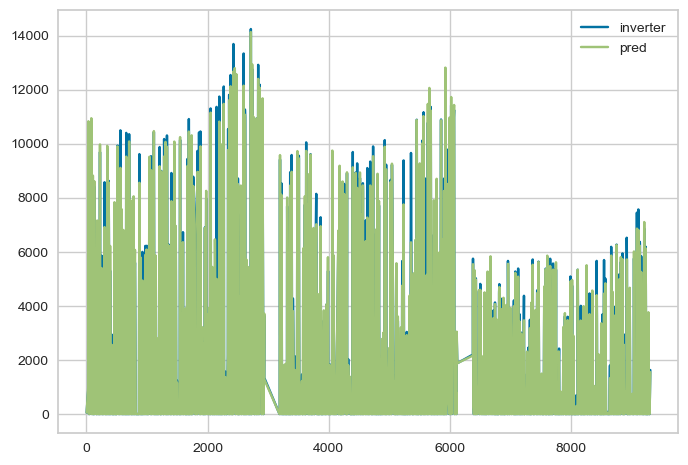

In [18]:
reg = XGBRegressor(random_state=1, max_depth=6, n_estimators=492, learning_rate=0.08897897857205937, subsample=0.5437984043218)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = data_test[['inverter']]
p['pred'] = y_pred

metric(p['inverter'],p['pred'])

p.sort_index()[['inverter','pred']].plot()

<Axes: >

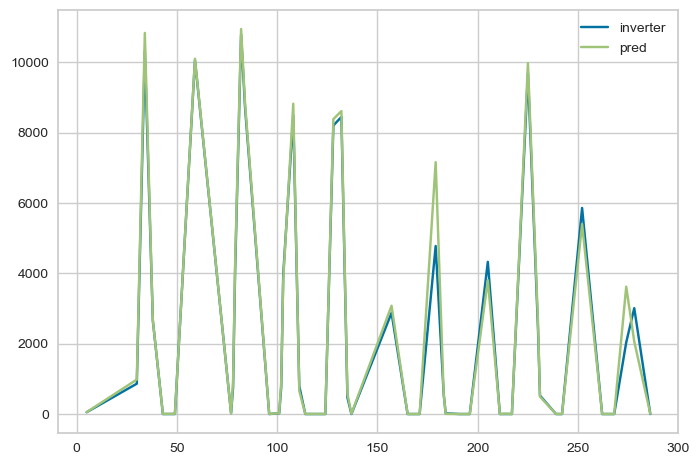

In [19]:
p.sort_index()[0:50].plot()

<Axes: xlabel='inverter', ylabel='pred'>

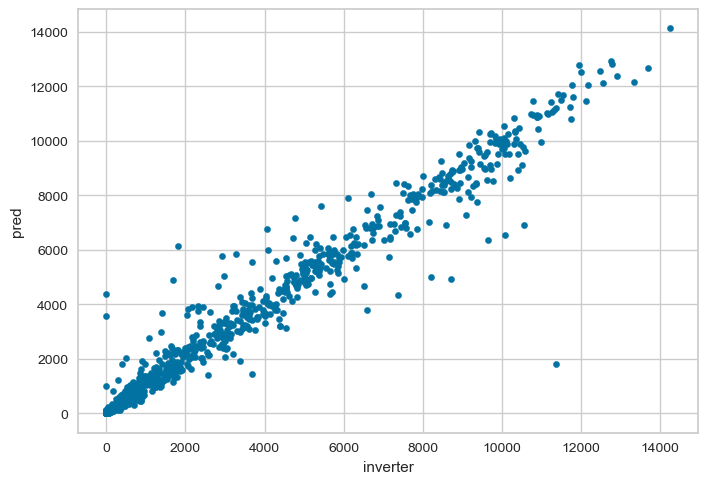

In [20]:
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# INVERTER1

In [126]:
data_train_1 = data_train[data_train['id']=='inverter1']
data_test_1 = data_test[data_test['id']=='inverter1']

In [127]:
X_train = data_train_1.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_1['inverter']

X_test = data_test_1.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_1['inverter']

In [128]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

## Gradient Boosting

CV R-squared:  0.9302472632326537
CV RMSE:  953.2745388961164
Adjusted R-squared - training:  0.9725292265708143


R-squared:  0.914952659931847
Adjusted R-squared:  0.9103720132495408
RMSE:  1071.259021987999


MAPE ML Model: 237.6064470995714
SMAPE ML Model: 55.62516208941823


<Axes: xlabel='inverter', ylabel='pred'>

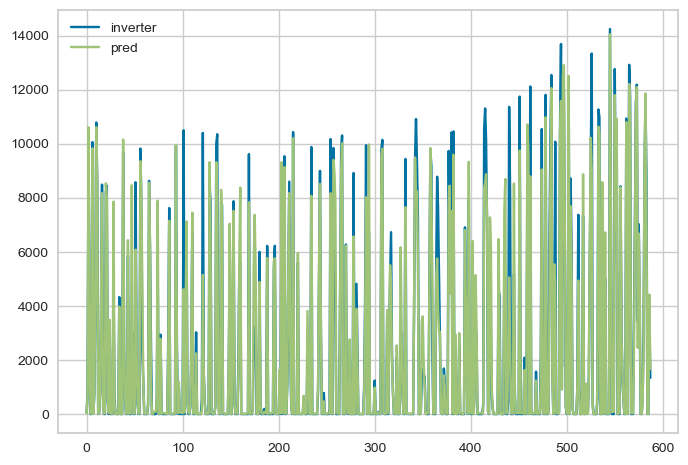

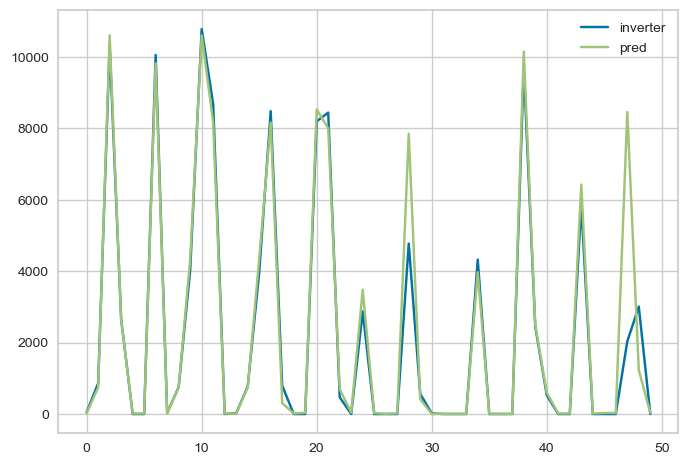

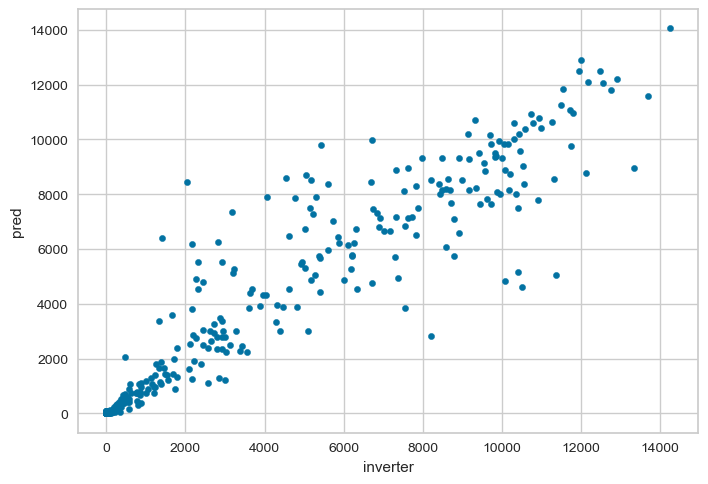

In [129]:
reg = GradientBoostingRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = GradientBoostingRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## XGBoost

CV R-squared:  0.9238315037729509
CV RMSE:  998.4248584437697
Adjusted R-squared - training:  0.9999335576748282


R-squared:  0.9139254640374864
Adjusted R-squared:  0.9092894926211931
RMSE:  1077.729964227643


MAPE ML Model: 80.47122991059582
SMAPE ML Model: 30.89758954372344


<Axes: xlabel='inverter', ylabel='pred'>

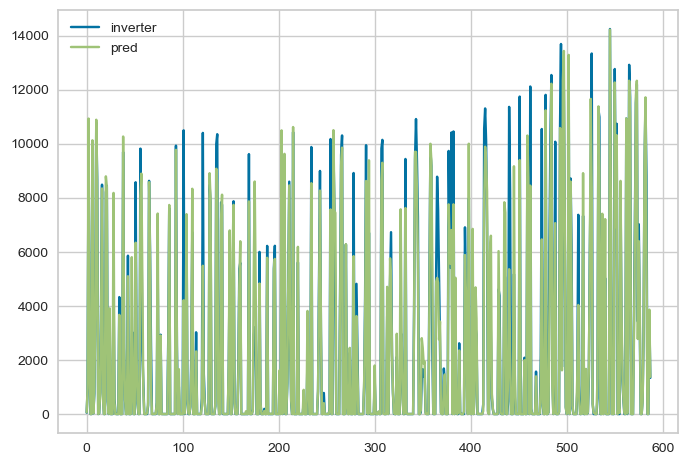

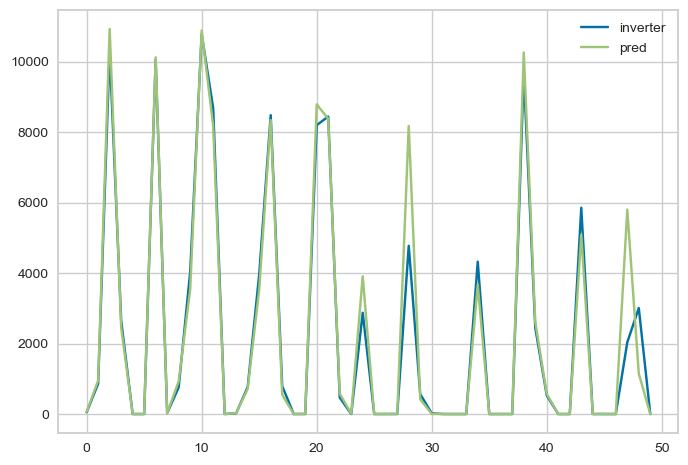

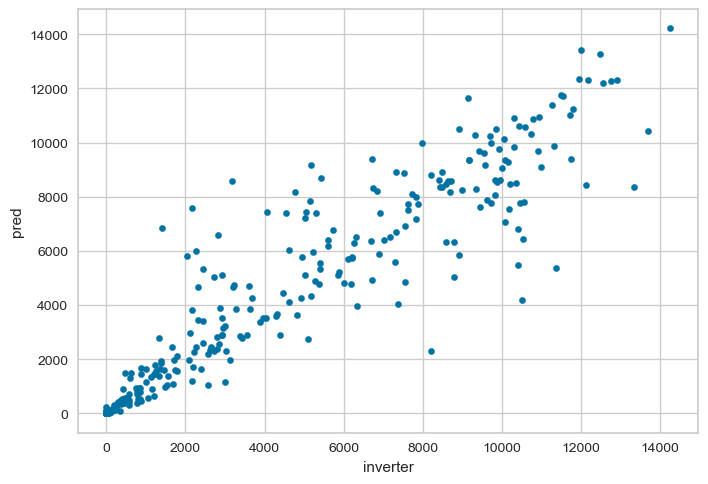

In [130]:
reg = XGBRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = XGBRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Random Forest

CV R-squared:  0.9295099595991578
CV RMSE:  958.500472675493
Adjusted R-squared - training:  0.9898626152379439


R-squared:  0.9177778502011966
Adjusted R-squared:  0.9133493681653544
RMSE:  1053.3708247542315


MAPE ML Model: 72.36987229664106
SMAPE ML Model: 7.04703016672183


<Axes: xlabel='inverter', ylabel='pred'>

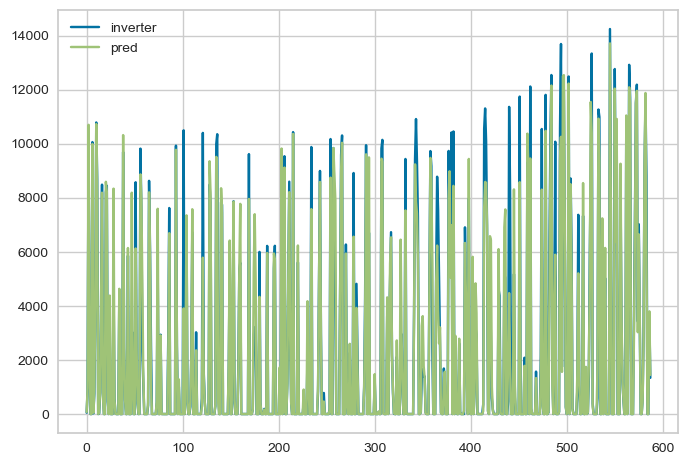

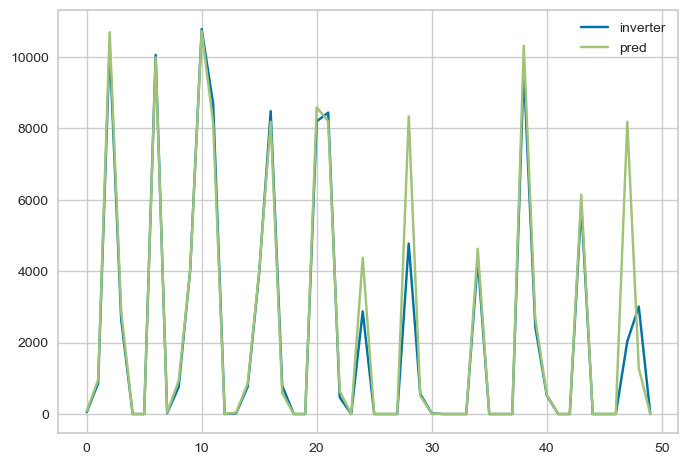

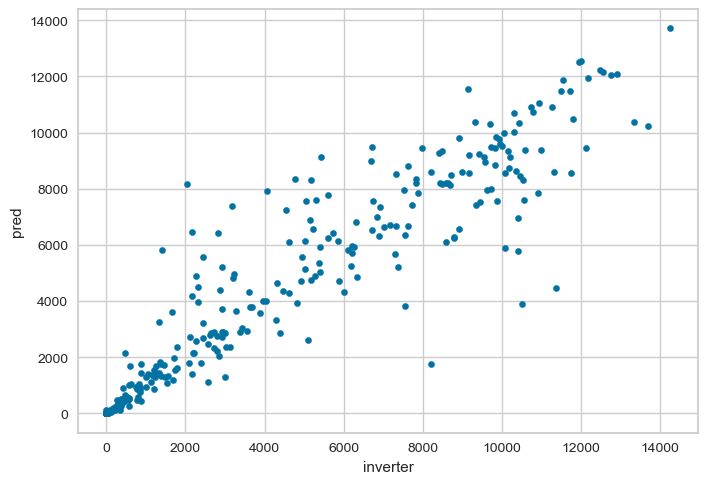

In [131]:
reg = RandomForestRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = RandomForestRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Extra Trees

CV R-squared:  0.9309613325472299
CV RMSE:  948.7694405813639
Adjusted R-squared - training:  1.0


R-squared:  0.9190587628344076
Adjusted R-squared:  0.9146992707069969
RMSE:  1045.1335534042485


MAPE ML Model: 88.3985749696108
SMAPE ML Model: 11.273815601153983


<Axes: xlabel='inverter', ylabel='pred'>

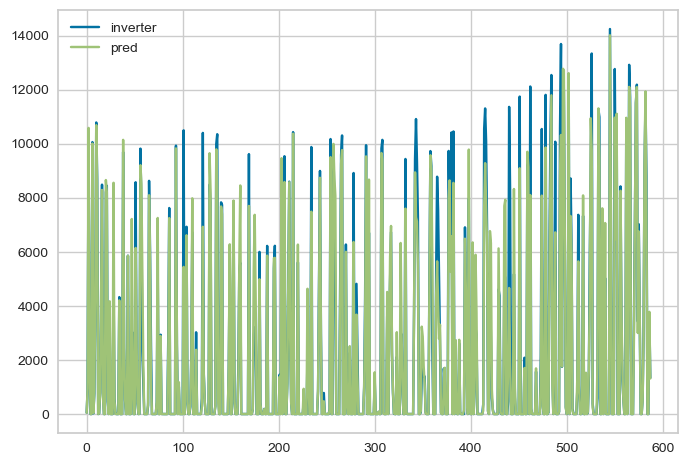

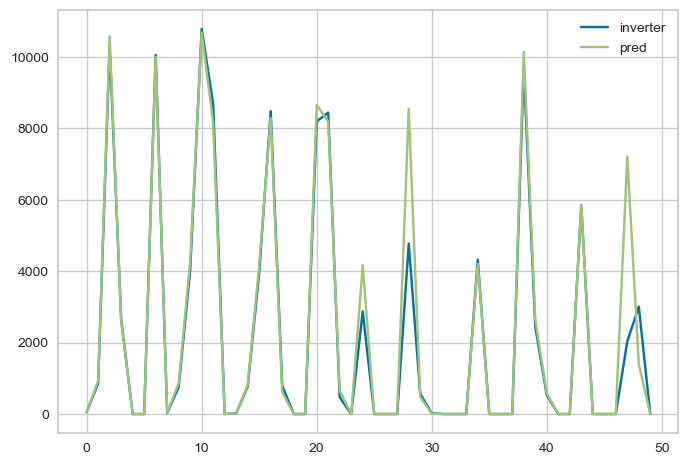

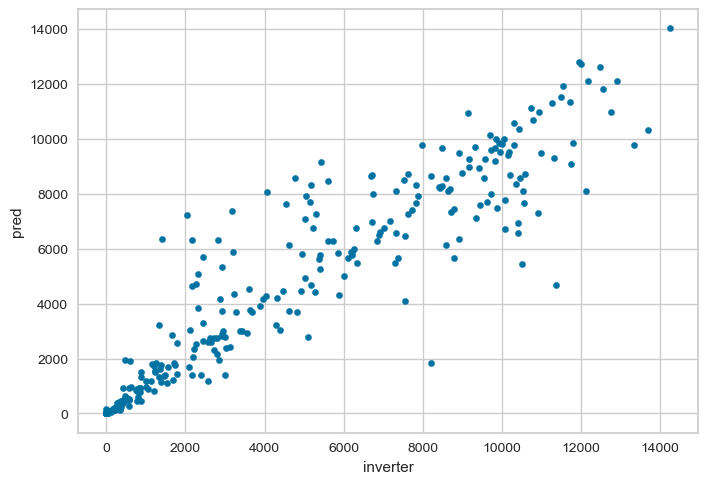

In [132]:
reg = ExtraTreesRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = ExtraTreesRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# INVERTER2

In [133]:
data_train_2 = data_train[data_train['id']=='inverter2']
data_test_2 = data_test[data_test['id']=='inverter2']

In [134]:
X_train = data_train_2.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_2['inverter']

X_test = data_test_2.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_2['inverter']

In [135]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

## Gradient Boosting

CV R-squared:  0.9229130545413649
CV RMSE:  913.0307706889674
Adjusted R-squared - training:  0.9725835287087671


R-squared:  0.9216788244639851
Adjusted R-squared:  0.9174905263069789
RMSE:  898.7305213492169


MAPE ML Model: 144.35646565865622
SMAPE ML Model: 54.60555885290081


<Axes: xlabel='inverter', ylabel='pred'>

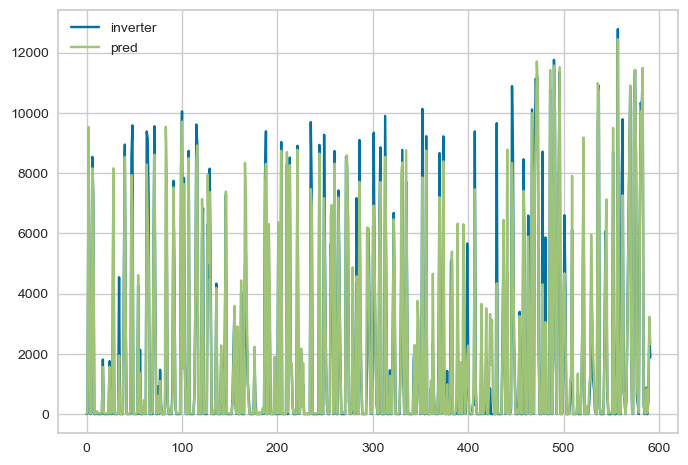

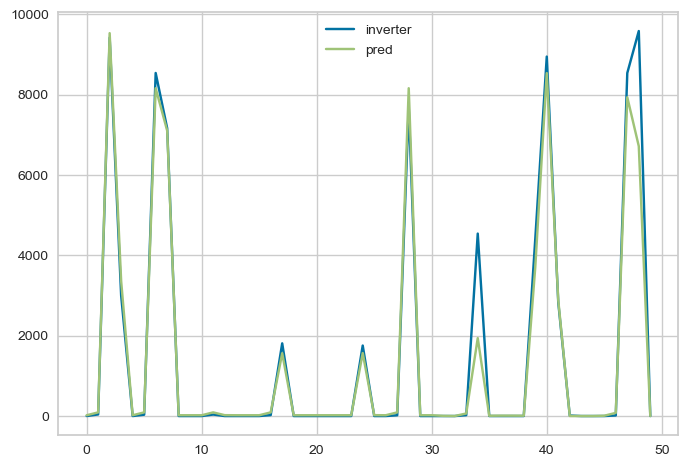

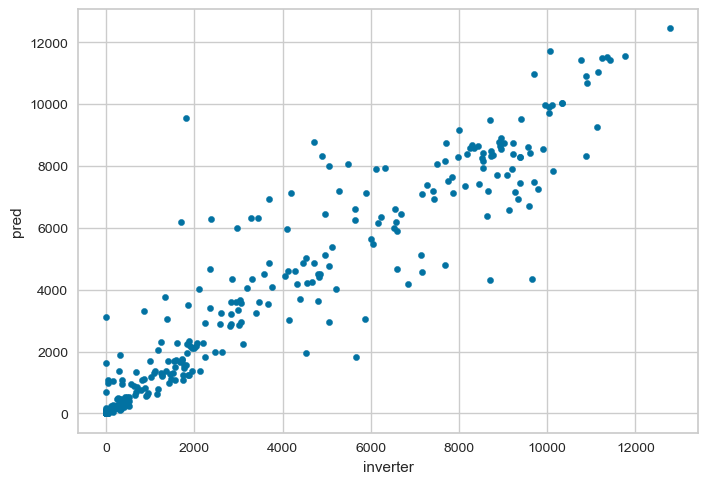

In [136]:
reg = GradientBoostingRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = GradientBoostingRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## XGBoost

CV R-squared:  0.9139919689529821
CV RMSE:  963.0269208567979
Adjusted R-squared - training:  0.9999259538202684


R-squared:  0.9181583518593088
Adjusted R-squared:  0.9137817931352077
RMSE:  918.6732937975635


MAPE ML Model: 84.57491563624882
SMAPE ML Model: 34.10545956391744


<Axes: xlabel='inverter', ylabel='pred'>

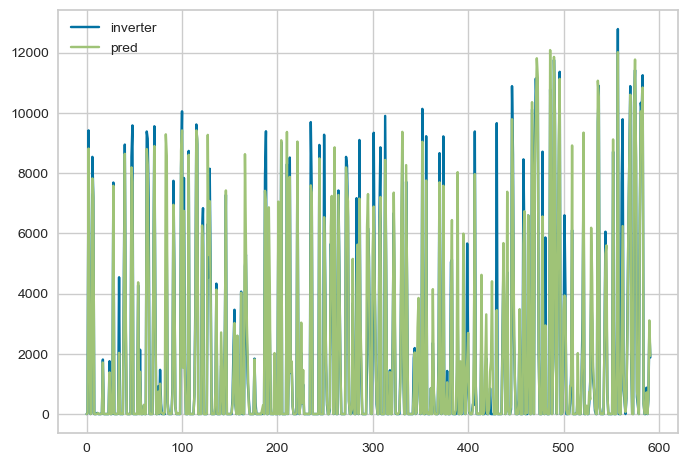

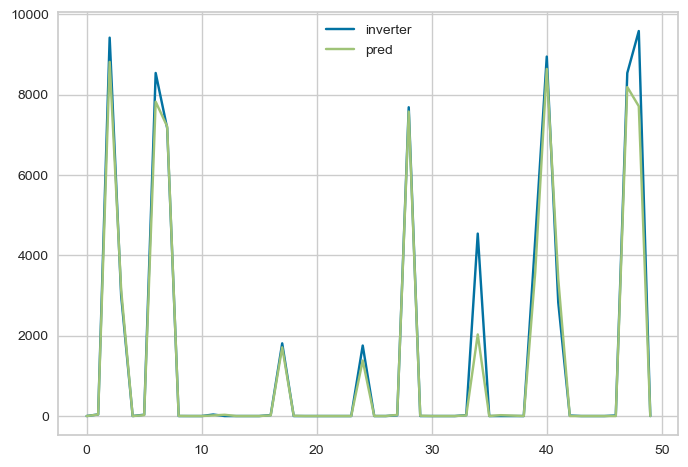

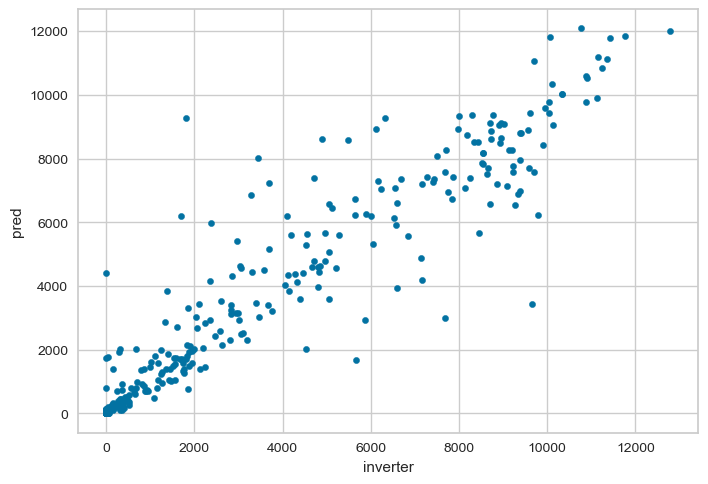

In [137]:
reg = XGBRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = XGBRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Random Forest

CV R-squared:  0.9225447182268507
CV RMSE:  913.102403902886
Adjusted R-squared - training:  0.9895105355788917


R-squared:  0.9245457570291321
Adjusted R-squared:  0.9205107707740054
RMSE:  882.1348209897309


MAPE ML Model: 50.408424669849886
SMAPE ML Model: 9.840228984266567


<Axes: xlabel='inverter', ylabel='pred'>

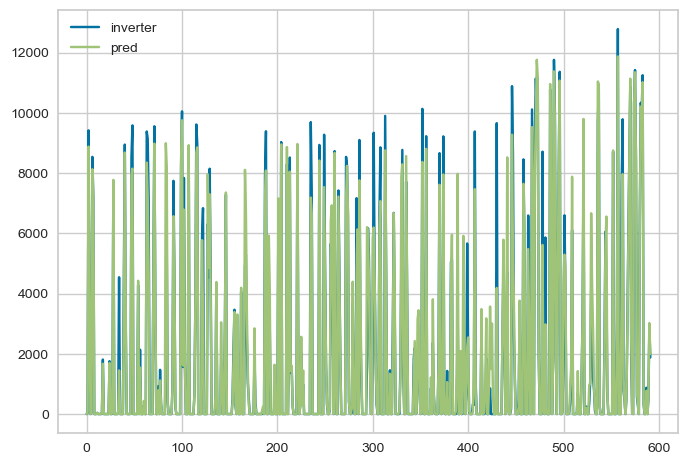

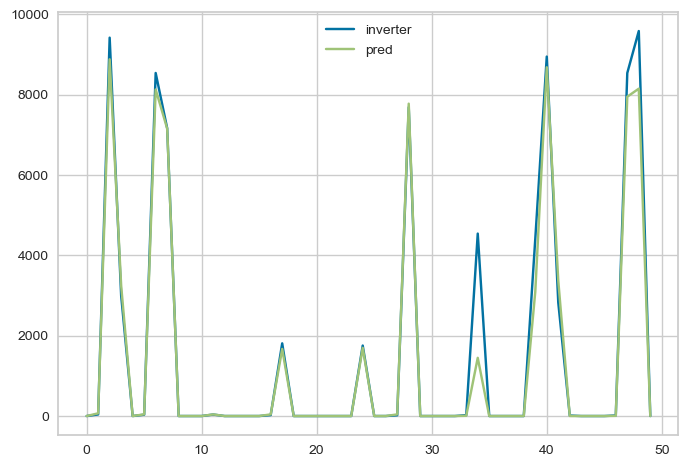

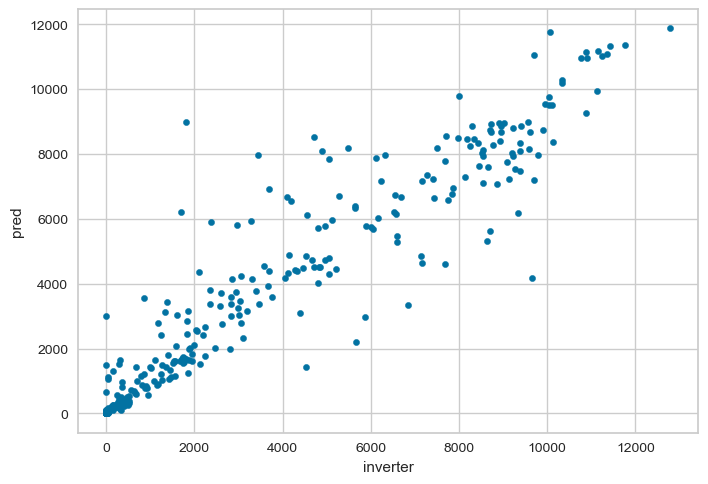

In [138]:
reg = RandomForestRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = RandomForestRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Extra Trees

CV R-squared:  0.9237667540501302
CV RMSE:  905.0655527468209
Adjusted R-squared - training:  1.0


R-squared:  0.9271189389083008
Adjusted R-squared:  0.9232215559622206
RMSE:  866.9628258902825


MAPE ML Model: 57.05140728609312
SMAPE ML Model: 14.306999911503175


<Axes: xlabel='inverter', ylabel='pred'>

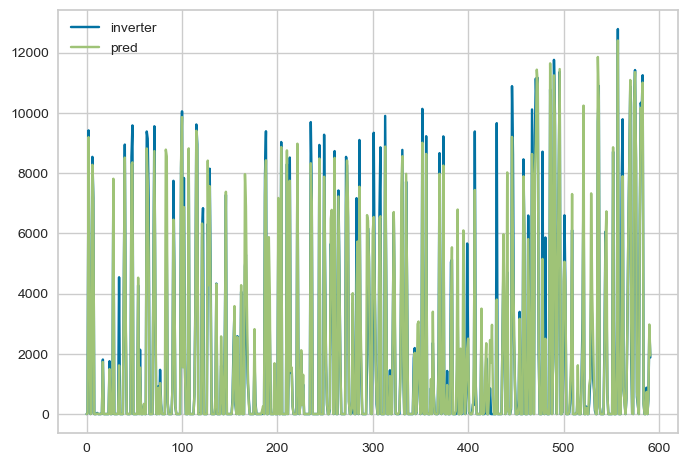

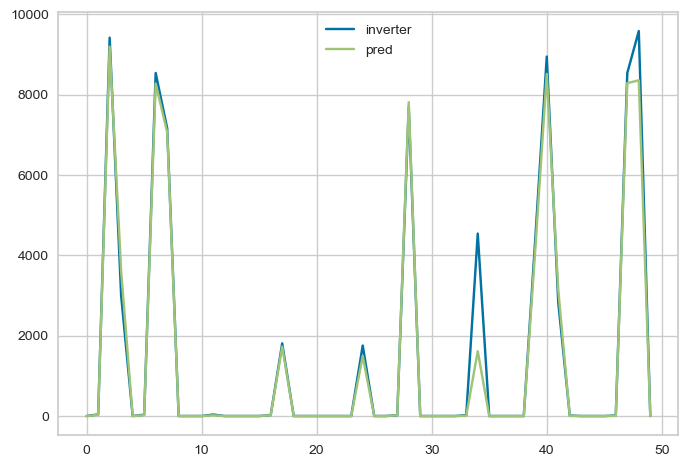

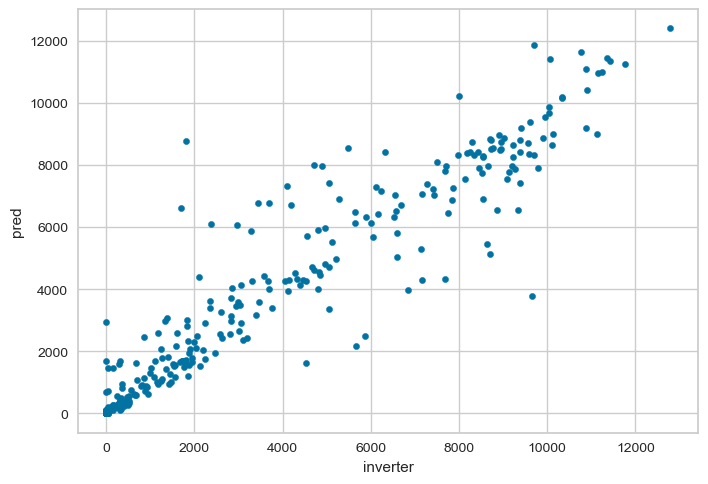

In [139]:
reg = ExtraTreesRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = ExtraTreesRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# INVERTER3

In [140]:
data_train_3 = data_train[data_train['id']=='inverter3']
data_test_3 = data_test[data_test['id']=='inverter3']

In [141]:
X_train = data_train_3.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_3['inverter']

X_test = data_test_3.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_3['inverter']

In [142]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

## Gradient Boosting

CV R-squared:  0.9197213610575847
CV RMSE:  548.8952232552772
Adjusted R-squared - training:  0.9681824834010251


R-squared:  0.9177686331957271
Adjusted R-squared:  0.9133236944495502
RMSE:  524.9054545080575


MAPE ML Model: 148.7832740233349
SMAPE ML Model: 58.535089932070285


<Axes: xlabel='inverter', ylabel='pred'>

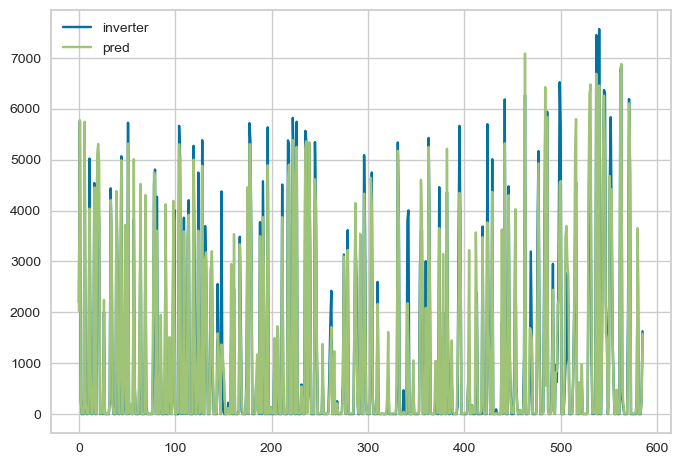

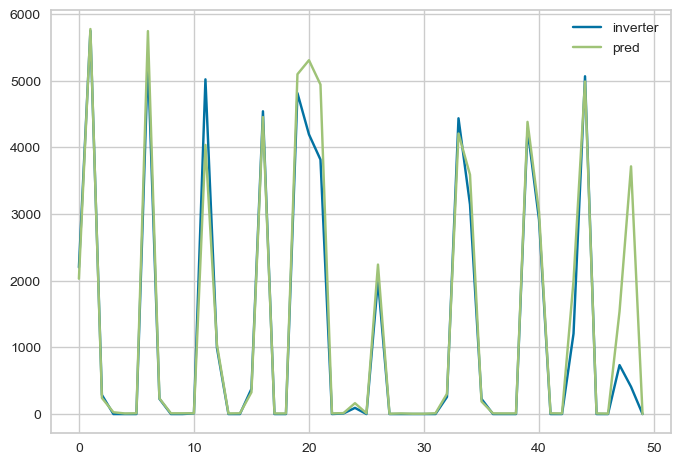

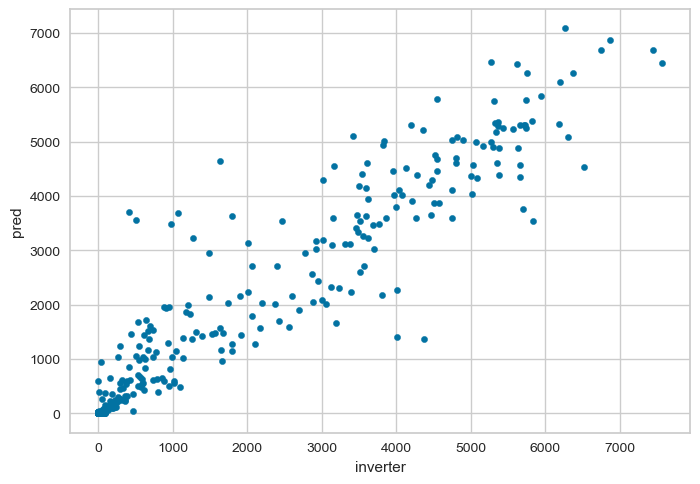

In [143]:
reg = GradientBoostingRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = GradientBoostingRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## XGBoost

CV R-squared:  0.9119806139259257
CV RMSE:  573.8027181987434
Adjusted R-squared - training:  0.9999295656682172


R-squared:  0.9226566324865326
Adjusted R-squared:  0.9184759099182371
RMSE:  509.051084405896


MAPE ML Model: 137.4281392417236
SMAPE ML Model: 33.49400554843477


<Axes: xlabel='inverter', ylabel='pred'>

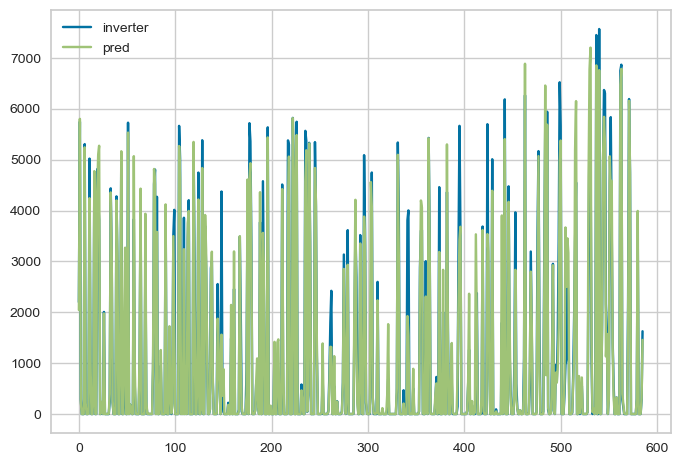

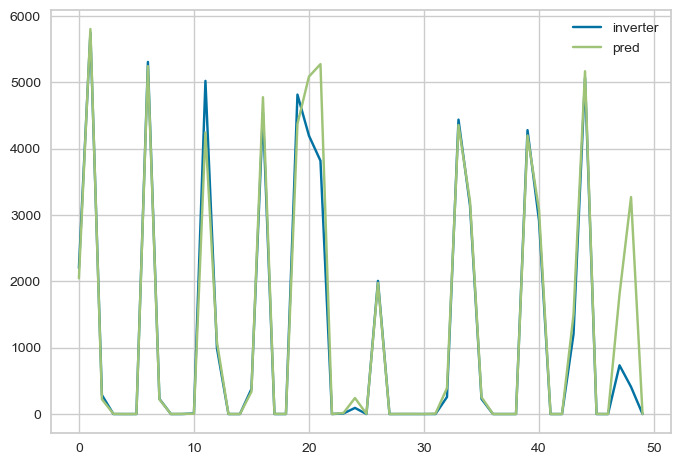

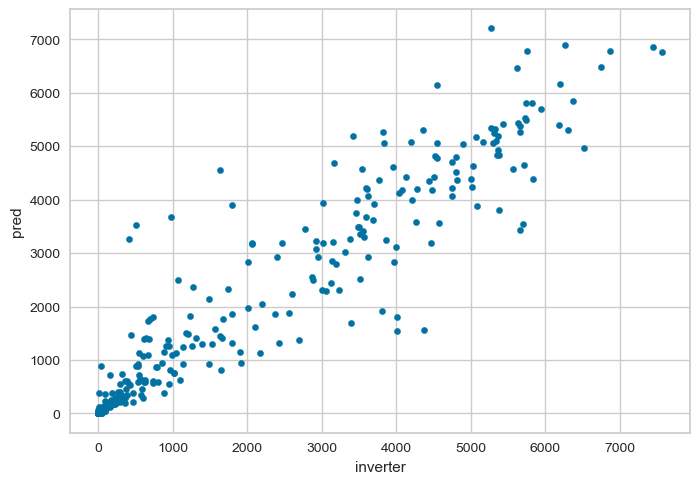

In [144]:
reg = XGBRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = XGBRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Random Forest

CV R-squared:  0.9207821264269175
CV RMSE:  543.9099903021495
Adjusted R-squared - training:  0.9890878204501807


R-squared:  0.9207860855498347
Adjusted R-squared:  0.9165042523363122
RMSE:  515.2066008259109


MAPE ML Model: 112.90440073935784
SMAPE ML Model: 9.215838517117755


<Axes: xlabel='inverter', ylabel='pred'>

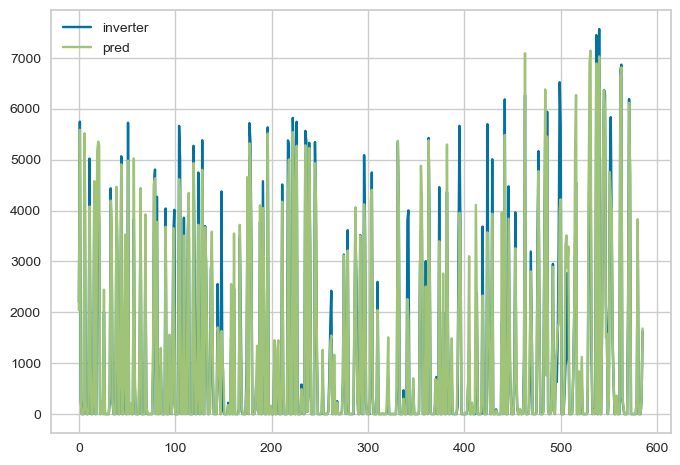

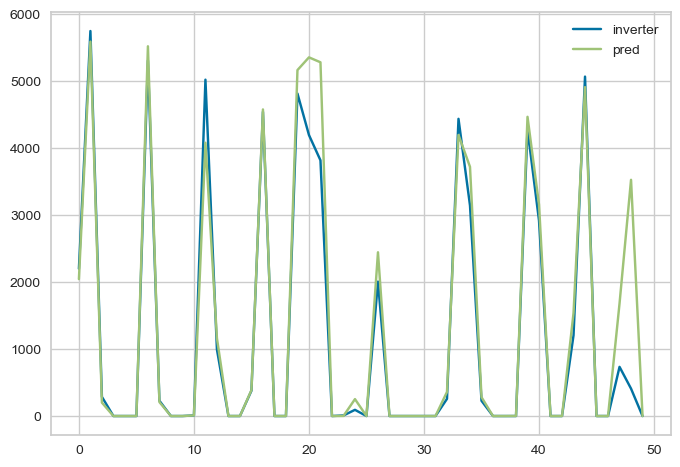

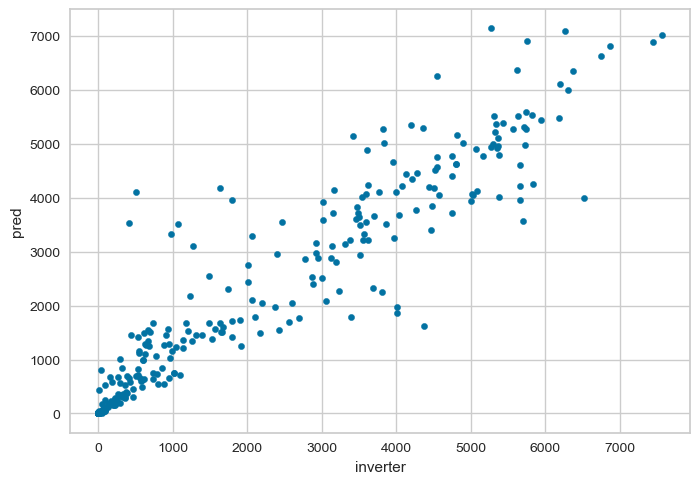

In [145]:
reg = RandomForestRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = RandomForestRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## Extra Trees

CV R-squared:  0.9227717045000862
CV RMSE:  536.9020880879447
Adjusted R-squared - training:  1.0


R-squared:  0.9239903414004619
Adjusted R-squared:  0.9198817112058922
RMSE:  504.6788119285404


MAPE ML Model: 129.32350135256573
SMAPE ML Model: 11.500167173888457


<Axes: xlabel='inverter', ylabel='pred'>

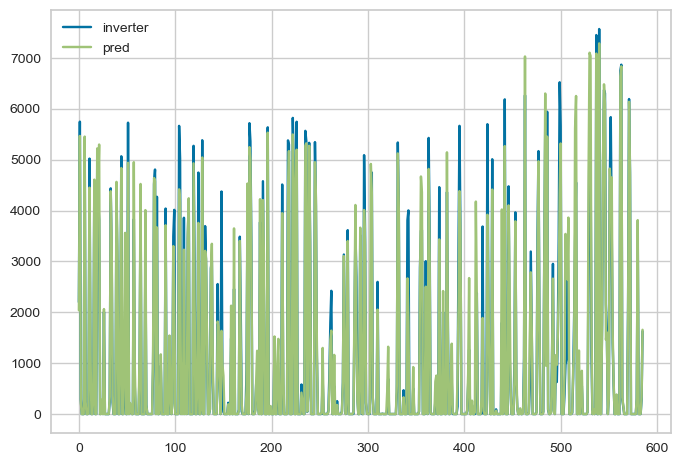

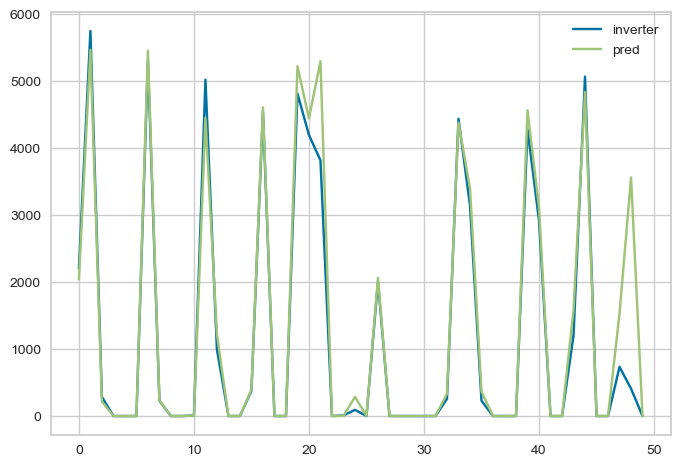

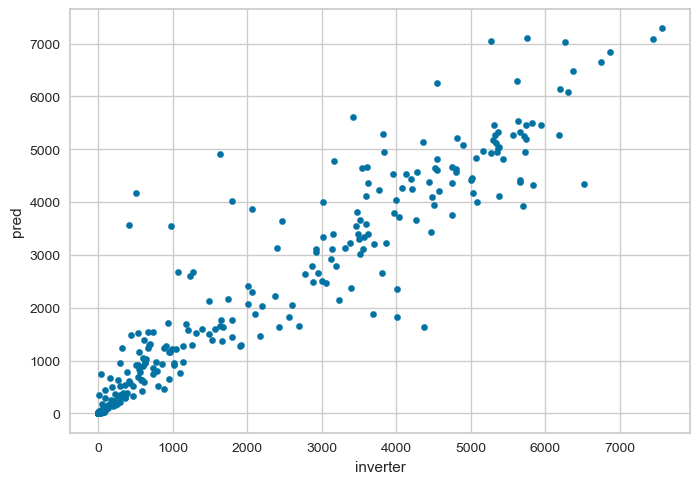

In [146]:
reg = ExtraTreesRegressor(random_state=1)

scores = cross_val_score(reg, X_train, y_train, cv=5) # R-squared
print('CV R-squared: ',scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') # R-squared
print('CV RMSE: ',-scores.mean())

reg = ExtraTreesRegressor(random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',reg.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# Random Forest - Optuna - FINAL MODELS - minimize smape

## INVERTER1

In [18]:
data_train_1 = data_train[data_train['id']=='inverter1']
data_test_1 = data_test[data_test['id']=='inverter1']

In [19]:
X_train = data_train_1.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_1['inverter']

X_test = data_test_1.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_1['inverter']

In [20]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

### minimize SMAPE

In [23]:
def smape(y_true,y_pred) :
    return 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

smape_score = make_scorer(smape)

In [22]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 14:27:10,029] A new study created in memory with name: no-name-b0700329-9e4c-48c5-b232-69efde955f82


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 14:30:21,212] Trial 2 finished with value: 57.97058382915479 and parameters: {'max_depth': 11, 'n_estimators': 166, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 57.97058382915479.
[I 2024-07-12 14:30:44,062] Trial 6 finished with value: 58.36775522126004 and parameters: {'max_depth': 6, 'n_estimators': 184, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 57.97058382915479.
[I 2024-07-12 14:31:12,647] Trial 11 finished with value: 58.00668076023982 and parameters: {'max_depth': 11, 'n_estimators': 211, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 2 with value: 57.97058382915479.
[I 2024-07-12 14:31:33,823] Trial 10 finished with value: 8.132329643651449 and parameters: {'max_depth': 25, 'n_estimators': 222, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 10 with value: 8.132329643651449.
[I 2024-07-12 14:32:32,413] Trial 3 finished with value: 59.72014222329443 and parameters: {'max_d

[I 2024-07-12 14:47:25,813] Trial 39 finished with value: 7.704523579696715 and parameters: {'max_depth': 27, 'n_estimators': 137, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 24 with value: 7.684328809947151.
[I 2024-07-12 14:47:26,388] Trial 40 finished with value: 13.0405949854517 and parameters: {'max_depth': 27, 'n_estimators': 143, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 24 with value: 7.684328809947151.
[I 2024-07-12 14:47:40,867] Trial 29 finished with value: 47.64140583697481 and parameters: {'max_depth': 16, 'n_estimators': 415, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 24 with value: 7.684328809947151.
[I 2024-07-12 14:47:48,591] Trial 38 finished with value: 7.690931625282881 and parameters: {'max_depth': 30, 'n_estimators': 147, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 24 with value: 7.684328809947151.
[I 2024-07-12 14:47:53,580] Trial 41 finished with value: 13.042389567454507 and parameters

[I 2024-07-12 14:59:17,366] Trial 76 finished with value: 7.663287983963416 and parameters: {'max_depth': 29, 'n_estimators': 112, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 69 with value: 7.634561388878916.
[I 2024-07-12 14:59:34,595] Trial 77 finished with value: 7.667146590576243 and parameters: {'max_depth': 29, 'n_estimators': 113, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 69 with value: 7.634561388878916.
[I 2024-07-12 14:59:53,046] Trial 78 finished with value: 7.663287983963416 and parameters: {'max_depth': 29, 'n_estimators': 112, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 69 with value: 7.634561388878916.
[I 2024-07-12 15:01:02,578] Trial 71 finished with value: 9.470901506709342 and parameters: {'max_depth': 29, 'n_estimators': 227, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 69 with value: 7.634561388878916.
[I 2024-07-12 15:01:30,495] Trial 79 finished with value: 7.666301819464667 and parameters: 

Best trial:

    Value:  7.634561388878916

Params: 
    
    max_depth: 29
    
    n_estimators: 229
    
    min_samples_split: 4
    
    min_samples_leaf: 1
    

In [23]:
rf_cl = RandomForestRegressor(max_depth = 29,n_estimators = 229,min_samples_split = 4,min_samples_leaf = 1, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([7.30095772, 7.94550524, 6.95098324, 7.03602352, 8.93933722])

Adjusted R-squared - training:  0.9883552226021237


R-squared:  0.9173556838228827
Adjusted R-squared:  0.9129044639210631
RMSE:  1056.0716078594357


MAPE ML Model: 70.44675767346429
SMAPE ML Model: 7.019559421263234


<Axes: xlabel='inverter', ylabel='pred'>

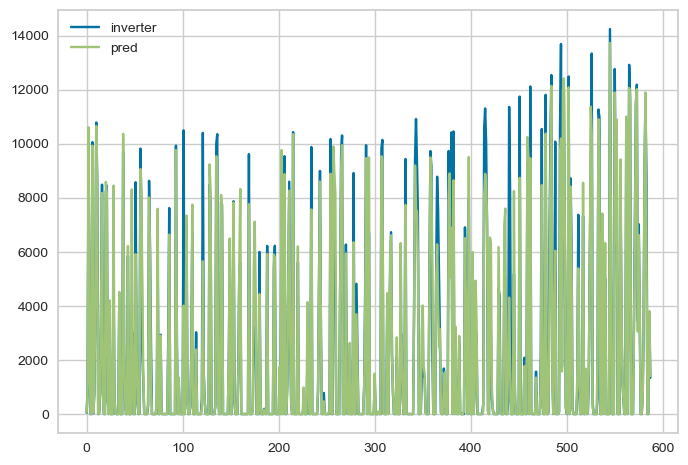

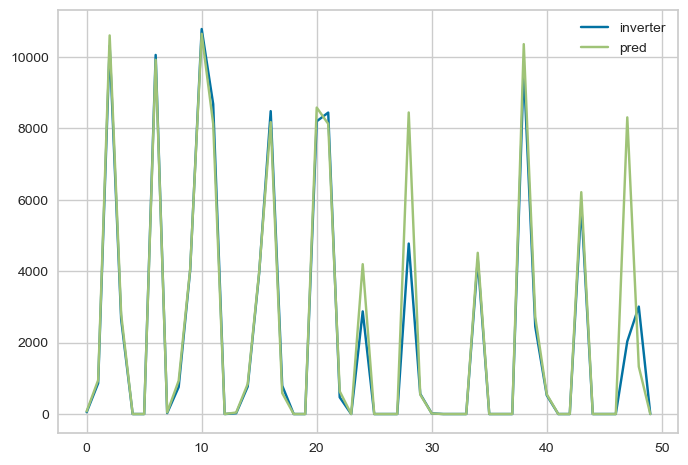

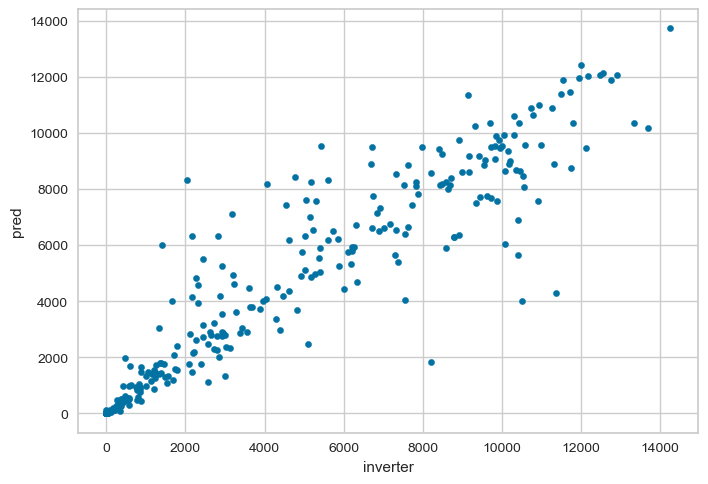

In [26]:
rf_cl = RandomForestRegressor(max_depth = 29,n_estimators = 229,min_samples_split = 4,min_samples_leaf = 1,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

### maximize R2

In [21]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 15:22:57,751] A new study created in memory with name: no-name-303bdd09-8f39-4308-8682-8b9af6efcca5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 15:23:29,064] Trial 0 finished with value: 0.9306521407702665 and parameters: {'max_depth': 28, 'n_estimators': 177, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9306521407702665.
[I 2024-07-12 15:23:40,892] Trial 6 finished with value: 0.9316126217222411 and parameters: {'max_depth': 21, 'n_estimators': 257, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.9316126217222411.
[I 2024-07-12 15:23:41,219] Trial 11 finished with value: 0.9317295537587466 and parameters: {'max_depth': 15, 'n_estimators': 264, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.9317295537587466.
[I 2024-07-12 15:23:43,628] Trial 7 finished with value: 0.9209629242201569 and parameters: {'max_depth': 3, 'n_estimators': 266, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.9317295537587466.
[I 2024-07-12 15:23:45,045] Trial 3 finished with value: 0.9317506645399783 and parameter

[I 2024-07-12 15:26:47,612] Trial 36 finished with value: 0.9316438447645806 and parameters: {'max_depth': 18, 'n_estimators': 441, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:26:47,992] Trial 37 finished with value: 0.9316528731022619 and parameters: {'max_depth': 18, 'n_estimators': 440, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:26:48,978] Trial 38 finished with value: 0.9317225566510767 and parameters: {'max_depth': 25, 'n_estimators': 445, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:26:51,662] Trial 39 finished with value: 0.9316641834923365 and parameters: {'max_depth': 18, 'n_estimators': 444, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:26:52,012] Trial 43 finished with value: 0.9316578577856254 and par

[I 2024-07-12 15:29:49,212] Trial 71 finished with value: 0.9316891399185572 and parameters: {'max_depth': 10, 'n_estimators': 313, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:29:49,863] Trial 77 finished with value: 0.9317399117762818 and parameters: {'max_depth': 11, 'n_estimators': 254, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:29:54,262] Trial 69 finished with value: 0.9317018417437183 and parameters: {'max_depth': 21, 'n_estimators': 409, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:29:56,895] Trial 76 finished with value: 0.9317335017705203 and parameters: {'max_depth': 11, 'n_estimators': 310, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.9318729208447305.
[I 2024-07-12 15:29:59,878] Trial 70 finished with value: 0.93167159242404 and param

Best trial:

    Value:  0.9320127142708825

Params: 
    
    max_depth: 28
    
    n_estimators: 387
    
    min_samples_split: 6
    
    min_samples_leaf: 3
    

In [24]:
rf_cl = RandomForestRegressor(max_depth = 28,n_estimators = 387,min_samples_split = 6,min_samples_leaf = 3, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([ 7.26996174,  8.70338005,  8.27152415,  9.59213894, 10.08399135])

Adjusted R-squared - training:  0.9808968569919878


R-squared:  0.917778967639815
Adjusted R-squared:  0.9133505457891767
RMSE:  1053.3636668214767


MAPE ML Model: 72.75971831106006
SMAPE ML Model: 8.073650941962416


<Axes: xlabel='inverter', ylabel='pred'>

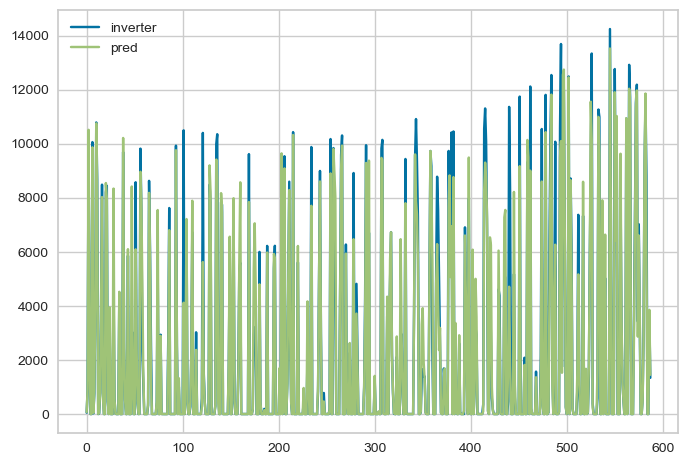

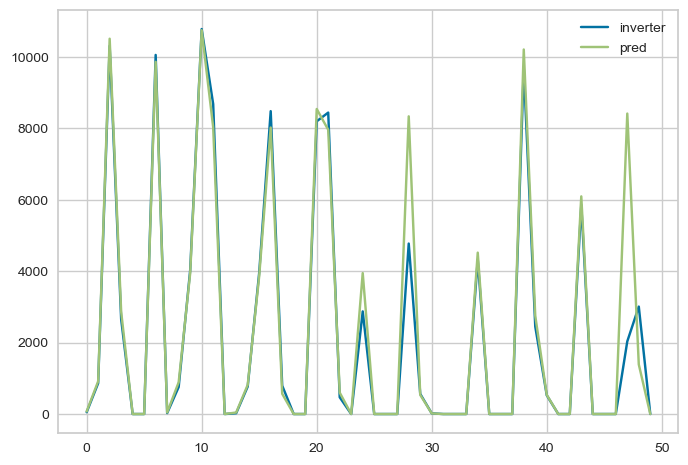

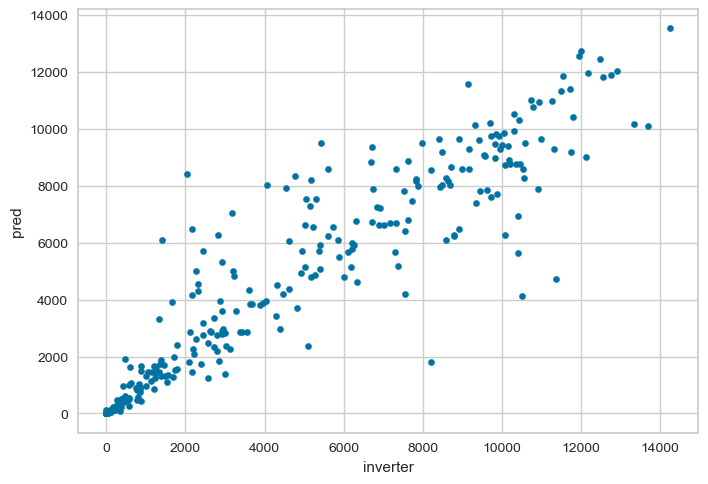

In [25]:
rf_cl = RandomForestRegressor(max_depth = 28,n_estimators = 387,min_samples_split = 6,min_samples_leaf = 3,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## INVERTER2

In [26]:
data_train_2 = data_train[data_train['id']=='inverter2']
data_test_2 = data_test[data_test['id']=='inverter2']

In [27]:
X_train = data_train_2.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_2['inverter']

X_test = data_test_2.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_2['inverter']

In [28]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

### minimize SMAPE

In [29]:
def smape(y_true,y_pred) :
    return 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

smape_score = make_scorer(smape)

In [30]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 15:33:21,481] A new study created in memory with name: no-name-e461c9dd-f75f-4899-8f3a-cb2f37365527


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 15:33:41,611] Trial 6 finished with value: 28.981381815072762 and parameters: {'max_depth': 15, 'n_estimators': 139, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 6 with value: 28.981381815072762.
[I 2024-07-12 15:33:44,579] Trial 5 finished with value: 14.323584935802998 and parameters: {'max_depth': 18, 'n_estimators': 165, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 5 with value: 14.323584935802998.
[I 2024-07-12 15:33:53,228] Trial 9 finished with value: 58.340862562816916 and parameters: {'max_depth': 10, 'n_estimators': 221, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 5 with value: 14.323584935802998.
[I 2024-07-12 15:33:59,562] Trial 12 finished with value: 14.074946778308794 and parameters: {'max_depth': 24, 'n_estimators': 118, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 12 with value: 14.074946778308794.
[I 2024-07-12 15:34:03,612] Trial 2 finished with value: 58.69451519127698 and parameters

[I 2024-07-12 15:36:13,712] Trial 38 finished with value: 8.574659069640946 and parameters: {'max_depth': 26, 'n_estimators': 177, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 29 with value: 8.156743958121291.
[I 2024-07-12 15:36:14,753] Trial 39 finished with value: 8.57424812896668 and parameters: {'max_depth': 27, 'n_estimators': 179, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 29 with value: 8.156743958121291.
[I 2024-07-12 15:36:17,246] Trial 37 finished with value: 8.69921792875962 and parameters: {'max_depth': 30, 'n_estimators': 199, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 29 with value: 8.156743958121291.
[I 2024-07-12 15:36:33,829] Trial 42 finished with value: 8.695653395400967 and parameters: {'max_depth': 27, 'n_estimators': 201, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 29 with value: 8.156743958121291.
[I 2024-07-12 15:36:37,914] Trial 44 finished with value: 8.310220363503467 and parameters: {'

[I 2024-07-12 15:38:48,862] Trial 73 finished with value: 8.255689908936702 and parameters: {'max_depth': 25, 'n_estimators': 252, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 69 with value: 8.154842343533312.
[I 2024-07-12 15:38:49,462] Trial 70 finished with value: 8.29572293746034 and parameters: {'max_depth': 25, 'n_estimators': 311, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 69 with value: 8.154842343533312.
[I 2024-07-12 15:38:53,947] Trial 74 finished with value: 8.299299440862718 and parameters: {'max_depth': 25, 'n_estimators': 257, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 69 with value: 8.154842343533312.
[I 2024-07-12 15:38:57,212] Trial 75 finished with value: 8.299954010023608 and parameters: {'max_depth': 25, 'n_estimators': 260, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 69 with value: 8.154842343533312.
[I 2024-07-12 15:39:08,078] Trial 76 finished with value: 8.255771726922474 and parameters: {

Best trial:

    Value:  8.143928247148882

Params: 
    
    max_depth: 25
    
    n_estimators: 146
    
    min_samples_split: 3
    
    min_samples_leaf: 1
    

In [31]:
rf_cl = RandomForestRegressor(max_depth = 25,n_estimators = 146,min_samples_split = 3,min_samples_leaf = 1, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([8.82440941, 7.127861  , 7.9524429 , 9.49371679, 7.32121114])

Adjusted R-squared - training:  0.9885951564270309


R-squared:  0.9238360263149606
Adjusted R-squared:  0.9197630865457072
RMSE:  886.2738381996485


MAPE ML Model: 50.63227531967417
SMAPE ML Model: 9.830320158946272


<Axes: xlabel='inverter', ylabel='pred'>

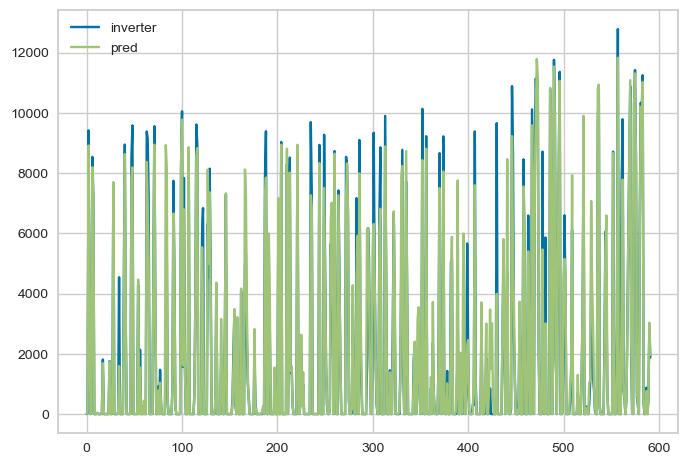

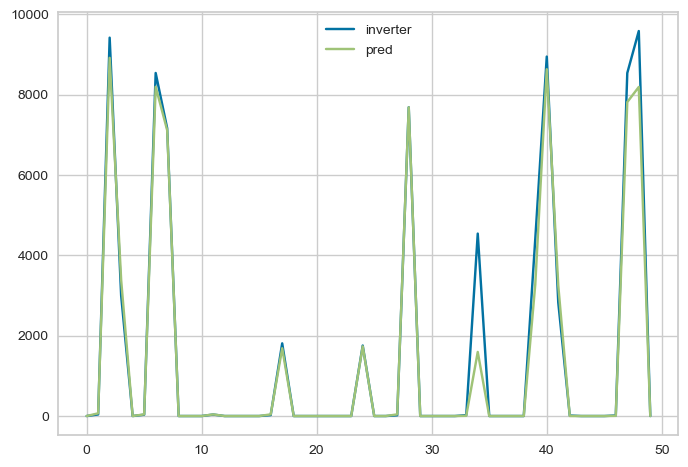

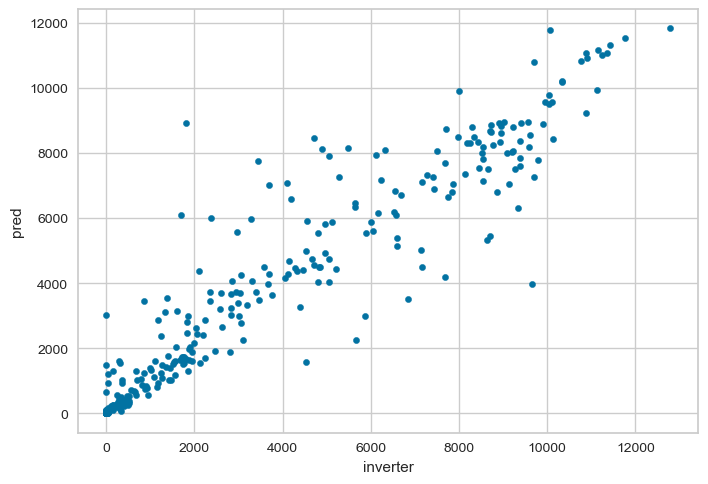

In [32]:
rf_cl = RandomForestRegressor(max_depth = 25,n_estimators = 146,min_samples_split = 3,min_samples_leaf = 1,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

### maximize R2

In [33]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 15:40:44,148] A new study created in memory with name: no-name-2b653974-3ec1-401d-9187-7c4915735737


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 15:41:02,066] Trial 4 finished with value: 0.9217567831451914 and parameters: {'max_depth': 12, 'n_estimators': 119, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9217567831451914.
[I 2024-07-12 15:41:08,595] Trial 9 finished with value: 0.9231212623595223 and parameters: {'max_depth': 26, 'n_estimators': 153, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.9231212623595223.
[I 2024-07-12 15:41:15,880] Trial 2 finished with value: 0.9225415554338733 and parameters: {'max_depth': 27, 'n_estimators': 210, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 9 with value: 0.9231212623595223.
[I 2024-07-12 15:41:16,425] Trial 6 finished with value: 0.9227732534144859 and parameters: {'max_depth': 24, 'n_estimators': 207, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 9 with value: 0.9231212623595223.
[I 2024-07-12 15:41:20,128] Trial 1 finished with value: 0.9216113756235871 and parameters:

[I 2024-07-12 15:43:15,312] Trial 37 finished with value: 0.9229886659269038 and parameters: {'max_depth': 28, 'n_estimators': 176, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:43:16,345] Trial 23 finished with value: 0.9229666023630833 and parameters: {'max_depth': 14, 'n_estimators': 498, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:43:20,145] Trial 38 finished with value: 0.9230303946481122 and parameters: {'max_depth': 27, 'n_estimators': 182, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:43:23,945] Trial 39 finished with value: 0.9231154302063647 and parameters: {'max_depth': 27, 'n_estimators': 189, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:43:24,139] Trial 42 finished with value: 0.9229143015868118 and par

[I 2024-07-12 15:44:50,578] Trial 73 finished with value: 0.9224538077029985 and parameters: {'max_depth': 29, 'n_estimators': 146, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:44:50,595] Trial 66 finished with value: 0.9223788737118112 and parameters: {'max_depth': 19, 'n_estimators': 201, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:44:53,429] Trial 67 finished with value: 0.9212613655421652 and parameters: {'max_depth': 23, 'n_estimators': 201, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:45:06,494] Trial 76 finished with value: 0.9230817310378127 and parameters: {'max_depth': 29, 'n_estimators': 149, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 27 with value: 0.9231357911755488.
[I 2024-07-12 15:45:07,114] Trial 79 finished with value: 0.9231357911755488 and par

Best trial:

    Value:  0.9231554598888942

Params: 
    
    max_depth: 28
    
    n_estimators: 151
    
    min_samples_split: 2
    
    min_samples_leaf: 3
    

In [34]:
rf_cl = RandomForestRegressor(max_depth = 28,n_estimators = 151,min_samples_split = 2,min_samples_leaf = 3, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([9.12034314, 7.78248812, 8.73941348, 9.64579467, 7.59109518])

Adjusted R-squared - training:  0.9785162516645426


R-squared:  0.9237093518940918
Adjusted R-squared:  0.9196296380916368
RMSE:  887.0105486019498


MAPE ML Model: 53.64982910453002
SMAPE ML Model: 11.720486134546661


<Axes: xlabel='inverter', ylabel='pred'>

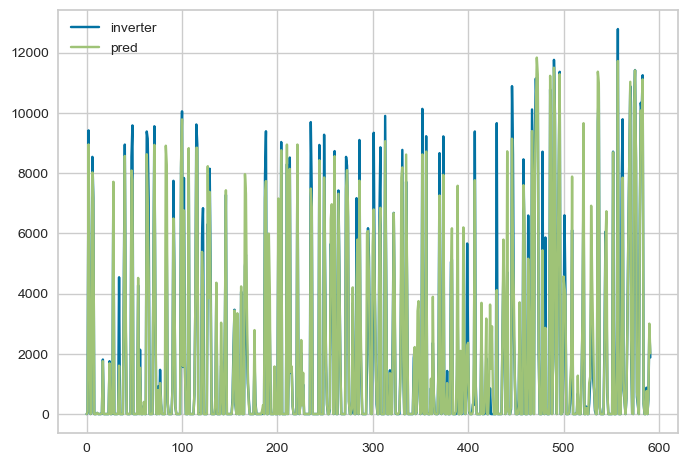

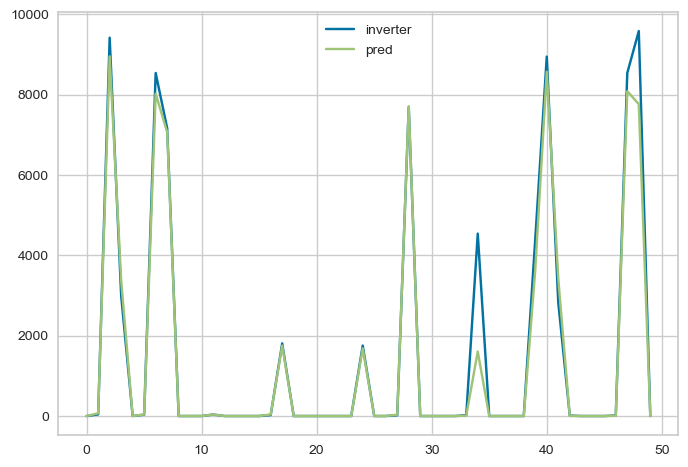

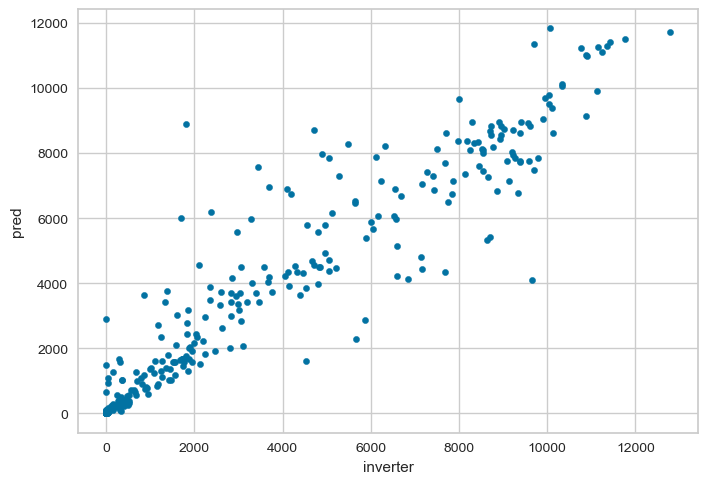

In [35]:
rf_cl = RandomForestRegressor(max_depth = 28,n_estimators = 151,min_samples_split = 2,min_samples_leaf = 3,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

## INVERTER3

In [36]:
data_train_3 = data_train[data_train['id']=='inverter3']
data_test_3 = data_test[data_test['id']=='inverter3']

In [37]:
X_train = data_train_3.drop(['datetime','id','inverter'],axis=1)
y_train = data_train_3['inverter']

X_test = data_test_3.drop(['datetime','id','inverter'],axis=1)
y_test = data_test_3['inverter']

In [38]:
X_train.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'wind_gusts_10m (km/h)', 'is_day ()',
       'sunshine_duration (s)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', 'terrestrial_radiation (W/m²)',
       'shortwave_radiation_instant (W/m²)', 'direct_radiation_instant (W/m²)',
       'diffuse_radiation_instant (W/m²)',
       'direct_normal_irradiance_instant (W/m²)',
       'terrestrial_radiation_instant (W/m²)', 'azimuth', 'zenith',
       'panel_size', 'energy', 'month', 'hour'],
      dtype='object')

### minimize SMAPE

In [39]:
def smape(y_true,y_pred) :
    return 100 * np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

smape_score = make_scorer(smape)

In [40]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 15:47:22,824] A new study created in memory with name: no-name-82b98ddd-9a4a-4f5d-9067-3504cf9f4a34


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 15:47:46,028] Trial 2 finished with value: 59.6080642224861 and parameters: {'max_depth': 11, 'n_estimators': 131, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 59.6080642224861.
[I 2024-07-12 15:47:46,214] Trial 1 finished with value: 10.190079497117027 and parameters: {'max_depth': 29, 'n_estimators': 142, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 10.190079497117027.
[I 2024-07-12 15:47:51,372] Trial 8 finished with value: 59.49397373636473 and parameters: {'max_depth': 13, 'n_estimators': 177, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 10.190079497117027.
[I 2024-07-12 15:47:57,228] Trial 5 finished with value: 10.719100550265054 and parameters: {'max_depth': 12, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 10.190079497117027.
[I 2024-07-12 15:48:09,478] Trial 10 finished with value: 10.490898336227895 and parameters: {'m

[I 2024-07-12 15:50:39,666] Trial 36 finished with value: 9.098488321899884 and parameters: {'max_depth': 26, 'n_estimators': 253, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 9 with value: 8.995309616866567.
[I 2024-07-12 15:50:41,228] Trial 44 finished with value: 8.891566102455373 and parameters: {'max_depth': 26, 'n_estimators': 104, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:50:44,595] Trial 39 finished with value: 9.067938668522391 and parameters: {'max_depth': 19, 'n_estimators': 238, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:50:45,012] Trial 37 finished with value: 9.057357892558054 and parameters: {'max_depth': 26, 'n_estimators': 246, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:50:47,129] Trial 45 finished with value: 8.934438962718515 and parameters: {

[I 2024-07-12 15:52:21,712] Trial 74 finished with value: 9.867493400310023 and parameters: {'max_depth': 27, 'n_estimators': 159, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:52:24,746] Trial 75 finished with value: 8.941765973129517 and parameters: {'max_depth': 27, 'n_estimators': 157, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:52:25,062] Trial 76 finished with value: 8.942465319136401 and parameters: {'max_depth': 27, 'n_estimators': 154, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:52:29,866] Trial 77 finished with value: 10.55565141187708 and parameters: {'max_depth': 27, 'n_estimators': 153, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 44 with value: 8.891566102455373.
[I 2024-07-12 15:52:33,445] Trial 78 finished with value: 10.553673935656139 and parameters:

Best trial:

    Value:  8.891566102455373
    
Params: 
    
    max_depth: 26
    
    n_estimators: 104
    
    min_samples_split: 5
    
    min_samples_leaf: 1
    

In [41]:
rf_cl = RandomForestRegressor(max_depth = 26,n_estimators = 104,min_samples_split = 5,min_samples_leaf = 1, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([ 8.65108367,  7.93103306,  8.62848103,  8.99293679, 10.25429596])

Adjusted R-squared - training:  0.9856577423150064


R-squared:  0.9202284403584922
Adjusted R-squared:  0.915916464161654
RMSE:  517.0168801431192


MAPE ML Model: 108.09322320245356
SMAPE ML Model: 9.241106052335041


<Axes: xlabel='inverter', ylabel='pred'>

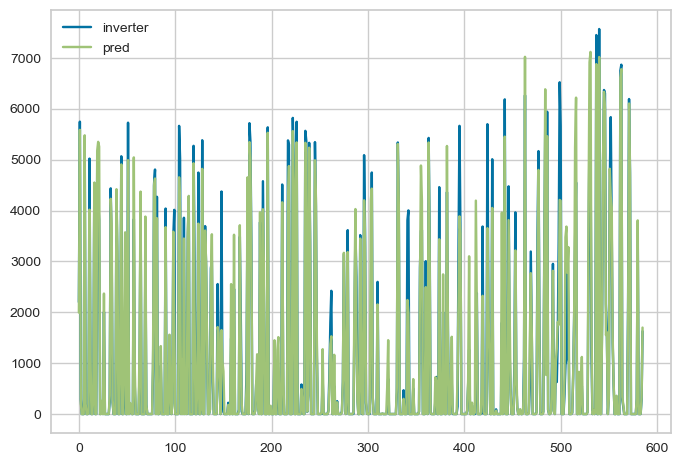

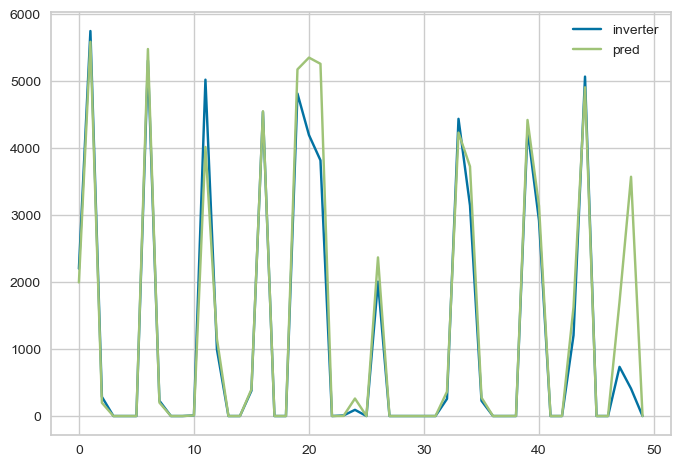

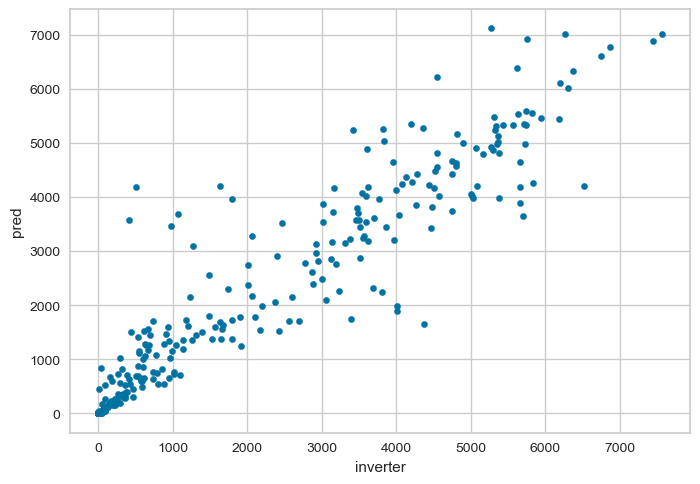

In [42]:
rf_cl = RandomForestRegressor(max_depth = 26,n_estimators = 104,min_samples_split = 5,min_samples_leaf = 1,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

### maximize R2

In [43]:
def _(doc):
    return doc

def objective(trial):

    rf_max_depth = trial.suggest_int("max_depth", 3, 30)
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 500)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf_cl = RandomForestRegressor(max_depth = rf_max_depth,n_estimators = rf_n_estimators,min_samples_split = rf_min_samples_split,min_samples_leaf = rf_min_samples_leaf,random_state = 1,n_jobs = -1)

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(rf_cl, X_train, y_train, cv=cv)

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-12 15:54:32,497] A new study created in memory with name: no-name-9f860d76-06a0-4ff3-a2c7-e8b01e7ccd43


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-12 15:54:57,428] Trial 11 finished with value: 0.9216005888276226 and parameters: {'max_depth': 7, 'n_estimators': 153, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.9216005888276226.
[I 2024-07-12 15:55:00,945] Trial 5 finished with value: 0.9227909219745698 and parameters: {'max_depth': 27, 'n_estimators': 171, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.9227909219745698.
[I 2024-07-12 15:55:01,628] Trial 6 finished with value: 0.9228622838006828 and parameters: {'max_depth': 15, 'n_estimators': 181, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9228622838006828.
[I 2024-07-12 15:55:05,312] Trial 3 finished with value: 0.922394788820706 and parameters: {'max_depth': 27, 'n_estimators': 204, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.9228622838006828.
[I 2024-07-12 15:55:05,508] Trial 9 finished with value: 0.9229021385922325 and parameters: 

[I 2024-07-12 15:58:15,526] Trial 36 finished with value: 0.9231574667540459 and parameters: {'max_depth': 11, 'n_estimators': 491, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.923403768893485.
[I 2024-07-12 15:58:21,612] Trial 37 finished with value: 0.9231773497766234 and parameters: {'max_depth': 24, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.923403768893485.
[I 2024-07-12 15:58:24,362] Trial 38 finished with value: 0.9231650893469292 and parameters: {'max_depth': 24, 'n_estimators': 388, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.923403768893485.
[I 2024-07-12 15:58:25,057] Trial 39 finished with value: 0.9232184860329891 and parameters: {'max_depth': 24, 'n_estimators': 377, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.923403768893485.
[I 2024-07-12 15:58:30,395] Trial 40 finished with value: 0.9230981249512892 and param

[I 2024-07-12 16:01:56,686] Trial 74 finished with value: 0.9234761108915555 and parameters: {'max_depth': 16, 'n_estimators': 330, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.9234761108915555.
[I 2024-07-12 16:02:02,112] Trial 73 finished with value: 0.9232791152534652 and parameters: {'max_depth': 22, 'n_estimators': 397, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.9234761108915555.
[I 2024-07-12 16:02:03,562] Trial 76 finished with value: 0.9233643210715528 and parameters: {'max_depth': 30, 'n_estimators': 327, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.9234761108915555.
[I 2024-07-12 16:02:07,015] Trial 71 finished with value: 0.9233550122682793 and parameters: {'max_depth': 17, 'n_estimators': 439, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.9234761108915555.
[I 2024-07-12 16:02:25,028] Trial 77 finished with value: 0.923274016295683 and para

Best trial:

    Value:  0.9234761108915555

Params: 
    
    max_depth: 16
    
    n_estimators: 330
    
    min_samples_split: 4
    
    min_samples_leaf: 2
    

In [44]:
rf_cl = RandomForestRegressor(max_depth = 16,n_estimators = 330,min_samples_split = 4,min_samples_leaf = 2, random_state = 1,n_jobs = -1)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(rf_cl, X_train, y_train, cv=cv, scoring = smape_score)

scores

array([ 8.60492168, 58.95862027,  8.75632407, 59.68970372, 58.0389999 ])

Adjusted R-squared - training:  0.9838098939623272


R-squared:  0.9230927783723837
Adjusted R-squared:  0.9189356312573774
RMSE:  507.64982658395735


MAPE ML Model: 142.43473760683992
SMAPE ML Model: 60.274572141649564


<Axes: xlabel='inverter', ylabel='pred'>

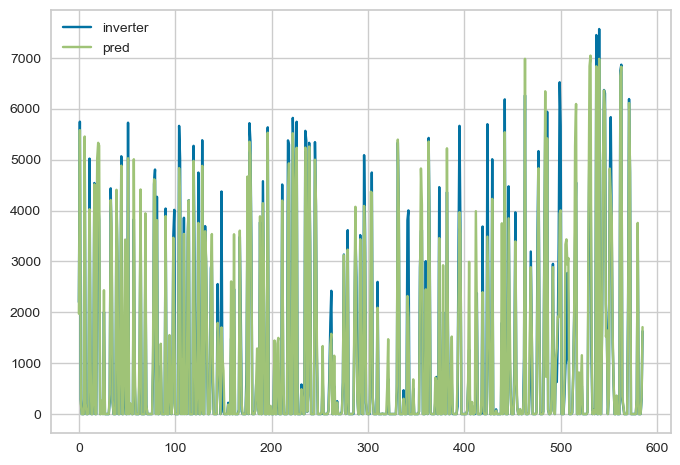

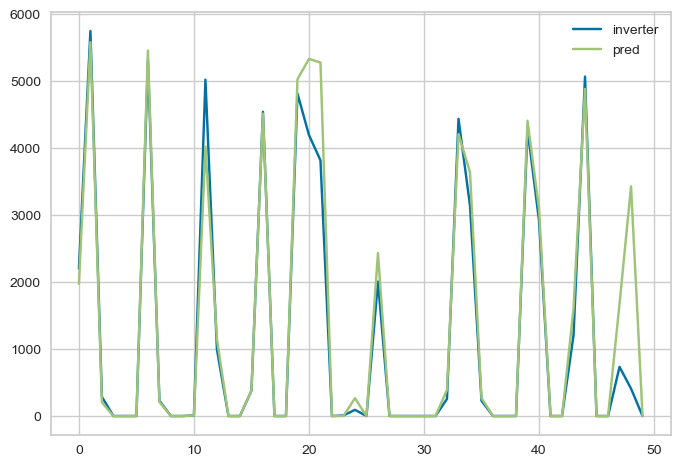

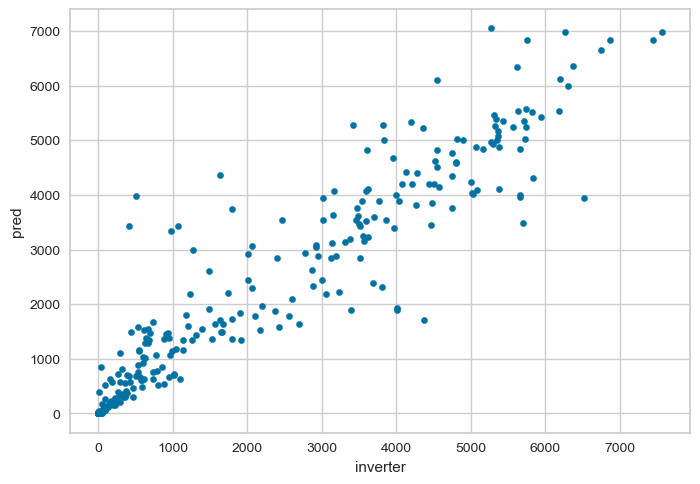

In [45]:
rf_cl = RandomForestRegressor(max_depth = 16,n_estimators = 330,min_samples_split = 4,min_samples_leaf = 2,
                              random_state = 1,n_jobs = -1)
rf_cl.fit(X_train,y_train)

y_pred = rf_cl.predict(X_test)
for i in range(len(y_pred)) :
    if y_pred[i] <0 :
        y_pred[i] = 0

print('Adjusted R-squared - training: ',1 - (1-rf_cl.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('\n')

print('R-squared: ',rf_cl.score(X_test, y_test)) # R-squared
print('Adjusted R-squared: ',1 - (1-rf_cl.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('RMSE: ',root_mean_squared_error(y_test, y_pred)) # RMSE
print('\n')

p = pd.DataFrame()
p['pred'] = y_pred
p['inverter'] = y_test.reset_index()['inverter']
p = p.sort_index()

metric(p['inverter'],p['pred'])

p[['inverter','pred']].plot()
p[['inverter','pred']][0:50].plot()
p[['inverter','pred']].plot.scatter(x='inverter',y='pred')

# evaluation

1. skoni
2. classification for fluctuations
3. api for solar zenith and azimuth